In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-08-10 20:15:22 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-08-10 20:15:22 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-08-10 20:15:22 __main__ INFO     transformers.__version__='4.54.1'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-08-10 20:15:24 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-08-10 20:15:24 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-08-10 20:15:25 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-08-10 20:15:25 wandb.docker.auth DEBUG    No config file found


In [4]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-08-10 20:15:25 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-08-10 20:15:25 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-08-10 20:15:26 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-08-10 20:15:26 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-08-10 20:15:26 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/meta-llama/Llama-3.3-70B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-08-10 20:16:15 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-08-10 20:16:15 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-08-10 20:16:15 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [5]:
# file_path = os.path.join(
#     env_utils.DEFAULT_DATA_DIR,
#     "selection",
#     # "profession.json"
#     # "nationality.json"
#     "objects.json",
# )

# with open(file_path, "r") as f:
#     temp = json.load(f)

# for cat in temp["categories"]:
#     temp["categories"][cat] = [obj.capitalize() for obj in temp["categories"][cat]]

# with open(file_path, "w") as f:
#     json.dump(temp, f, indent=4)


In [6]:
from src.selection.data import SelectOneTask

select_prof = SelectOneTask.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)

print(select_prof)

SelectOneTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



In [7]:
sample = select_prof.get_random_sample(
    mt = mt,
    # prompt_template_idx=2,
    # option_style="numbered",
    prompt_template_idx=3,
    option_style="single_line",
    # category="actor"
    # category="Brazil"
    # category="fruit",
    filter_by_lm_prediction=False,
)

print(sample)

Food processor -> Slow cooker (3): ['Tiger', 'Eraser', 'Speaker', 'Slow cooker', 'Pendant', 'Baseball']


In [8]:
from src.functional import predict_next_token
# sample.prompt_template = select_prof.prompt_templates[3]
print(f'"{sample.prompt()}"', ">>", sample.obj)

predict_next_token(
    mt=mt,
    inputs=sample.prompt()
)

"Options: Tiger, Eraser, Speaker, Slow cooker, Pendant, Baseball.
Which among these objects mentioned above is a kitchen appliance?
Answer:" >> Slow cooker


[[PredictedToken(token=' Slow', prob=0.81640625, logit=22.125, token_id=39247, metadata=None),
  PredictedToken(token=' A', prob=0.05908203125, logit=19.5, token_id=362, metadata=None),
  PredictedToken(token=' The', prob=0.05224609375, logit=19.375, token_id=578, metadata=None),
  PredictedToken(token=' Among', prob=0.04052734375, logit=19.125, token_id=22395, metadata=None),
  PredictedToken(token=' slow', prob=0.00799560546875, logit=17.5, token_id=6435, metadata=None)]]

In [9]:
print(sample.prompt(option_style="single_line"))

Options: Tiger, Eraser, Speaker, Slow cooker, Pendant, Baseball.
Which among these objects mentioned above is a kitchen appliance?
Answer:


In [10]:
from src.functional import generate_with_patch

gen = generate_with_patch(
    mt = mt,
    inputs = sample.prompt(),
    max_new_tokens=20,
    do_sample=False,
    remove_prefix=True
)[0]
print(f'"{gen}"', ">>", sample.obj)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


" Slow cooker.
Explanation: A slow cooker is a kitchen appliance used for cooking food over a long period" >> Slow cooker


In [11]:
from src.attention import get_attention_matrices
from src.experiments.utils import (
    get_patches_to_verify_independent_enrichment,
    verify_head_patterns,
)

HEADS = [
    (33, 45),
    (33, 18),
    (34, 1),
    (34, 6),
    (34, 7),
    (35, 19),
    (39, 40),
    (42, 30),
    (47, 18),
    (52, 58),
]

attn_pattern = verify_head_patterns(
    prompt = sample.prompt(),
    options = sample.options,
    pivot = sample.subj,
    mt = mt,
    heads = HEADS
)

0 patches to ablate possible answer information from options
2025-08-10 20:16:20 src.experiments.utils DEBUG    Predictions: ['" Slow"[39247] (p=0.816, logit=22.125)', '" A"[362] (p=0.059, logit=19.500)', '" The"[578] (p=0.052, logit=19.375)', '" Among"[22395] (p=0.041, logit=19.125)', '" slow"[6435] (p=0.008, logit=17.500)']
2025-08-10 20:16:20 src.experiments.utils INFO     Combined attention matrix for all heads


In [12]:
select_prof.category_wise_examples.keys()

dict_keys(['fruit', 'vehicle', 'furniture', 'animal', 'music instrument', 'clothing', 'electronics', 'sport equipment', 'kitchen appliance', 'vegetable', 'building', 'office supply', 'bathroom item', 'flower', 'tree', 'jewelry'])

In [13]:
import copy
import random
from src.selection.utils import KeyedSet, get_first_token_id
from src.selection.data import SelectionSample
from src.functional import predict_next_token

######################################################################
N_DISTRACTORS = 5
WINDOW_SPEC = {
    mt.layer_name_format: 1,
    mt.mlp_module_name_format: 9,
    mt.attn_module_name_format: 9,
}
module_name_format = mt.layer_name_format
# module_name_format = mt.mlp_module_name_format
# module_name_format = mt.attn_module_name_format

######################################################################


def get_counterfactual_samples_on_pivot_entity(
    task: SelectOneTask = select_prof,
    patch_category: str | None = None,
    clean_category: str | None = None,
    shuffle_clean_options: bool = False,
    prompt_template_idx=2,
    option_style="numbered",
    filter_by_lm_prediction: bool = True,
    distinct_options: bool = False,
):
    categories = list(task.category_wise_examples.keys())
    if patch_category is None:
        patch_category = random.choice(categories)

    patch_subj, patch_obj = random.sample(
        task.category_wise_examples[patch_category], 2
    )
    logger.info(
        f"Patch category: {patch_category}, subject: {patch_subj}, object: {patch_obj}"
    )

    if clean_category is None:
        clean_category = random.choice(list(set(categories) - {patch_category}))

    clean_options = task.category_wise_examples[clean_category]
    random.shuffle(clean_options)

    clean_subj, clean_obj = random.sample(
        (KeyedSet(clean_options, mt.tokenizer) - KeyedSet([patch_obj], mt.tokenizer)).values, 2
    )
    logger.info(
        f"Clean category: {clean_category}, subject: {clean_subj}, object: {clean_obj}"
    )

    if distinct_options is False:
        # patch_must_have_options = [patch_obj, clean_obj]
        # clean_must_have_options = [clean_obj, patch_obj]
        patch_type_obj = patch_obj
        clean_type_obj = clean_obj
    else:
        patch_type_obj = random.choice(
            (KeyedSet(task.category_wise_examples[patch_category], mt.tokenizer) - KeyedSet([patch_obj], mt.tokenizer)).values
        )
        clean_type_obj = random.choice(
            (KeyedSet(task.category_wise_examples[clean_category], mt.tokenizer) - KeyedSet([clean_obj], mt.tokenizer)).values
        )

    patch_must_have_options = [patch_obj, clean_type_obj]
    clean_must_have_options = [clean_obj, patch_type_obj]

    logger.info(f"{patch_must_have_options=}")
    logger.info(f"{clean_must_have_options=}")
    logger.info(f"{clean_type_obj=}")
    logger.info(f"{patch_type_obj=}")

    patch_distractors = []
    other_categories = random.sample(
        list(set(categories) - {patch_category, clean_category}),
        k=N_DISTRACTORS - (len(patch_must_have_options)) + 1,
    )

    for other_category in other_categories:
        other_examples = task.category_wise_examples[other_category]
        random.shuffle(other_examples)
        other_examples = KeyedSet(other_examples, mt.tokenizer)
        patch_distractors.append(
            random.choice(
                (
                    other_examples
                    - KeyedSet(
                        patch_must_have_options + patch_distractors, tokenizer=mt.tokenizer
                    )
                ).values
            )
        )

    patch_options = patch_must_have_options + patch_distractors
    random.shuffle(patch_options)
    patch_obj_idx = patch_options.index(patch_obj)
    logger.info(f"{patch_obj_idx=} | {patch_options}")

    if distinct_options is not True:
        clean_options = copy.deepcopy(patch_options)
        if shuffle_clean_options:
            # Useful for the pointer experiments
            while (
                clean_options.index(clean_obj) == patch_obj_idx
                or clean_options.index(patch_obj) == patch_obj_idx
            ):
                random.shuffle(clean_options)
        clean_obj_idx = clean_options.index(clean_obj)

    else:
        other_categories = random.sample(
            list(set(categories) - {patch_category, clean_category}),
            k=N_DISTRACTORS - (len(clean_must_have_options)) + 1,
        )
        clean_distractors = []
        for other_category in other_categories:
            other_examples = task.category_wise_examples[other_category]
            random.shuffle(other_examples)
            other_examples = KeyedSet(other_examples, mt.tokenizer)
            clean_distractors.append(
                random.choice(
                    (
                        other_examples
                        - KeyedSet(
                            clean_must_have_options + clean_distractors, tokenizer=mt.tokenizer
                        )
                    ).values
                )
            )
        clean_options = clean_must_have_options + clean_distractors
        random.shuffle(clean_options)
        clean_obj_idx = clean_options.index(clean_obj)

    logger.info(f"{clean_obj_idx=} | {clean_options}")

    kwargs = dict(
        prompt_template= task.prompt_templates[prompt_template_idx],
        default_option_style=option_style,
    )
    patch_metadata = {
        "track_category": clean_category, 
        "track_type_obj": clean_type_obj,
        "track_type_obj_idx": patch_options.index(clean_type_obj),
        "track_type_obj_token_id": get_first_token_id(
            clean_type_obj, mt.tokenizer, prefix=" "
        ),
    }
    clean_metadata = {
        "track_category": patch_category,
        "track_type_obj": patch_type_obj,
        "track_type_obj_idx": clean_options.index(patch_type_obj),
        "track_type_obj_token_id": get_first_token_id(
            patch_type_obj, mt.tokenizer, prefix=" "
        ),
    }

    patch_sample = SelectionSample(
        subj=patch_subj,
        obj=patch_obj,
        obj_idx=patch_obj_idx,
        obj_token_id=get_first_token_id(patch_obj, mt.tokenizer, prefix=" "),
        options=patch_options,
        category=patch_category,
        metadata = patch_metadata,
        **kwargs,
    )
    clean_sample = SelectionSample(
        subj=clean_subj,
        obj=clean_obj,
        obj_idx=clean_obj_idx,
        obj_token_id=get_first_token_id(clean_obj, mt.tokenizer, prefix=" "),
        options=clean_options,
        category=clean_category,
        metadata = clean_metadata,
        **kwargs,
    )

    if filter_by_lm_prediction:
        test_samples = [patch_sample, clean_sample]
        if distinct_options is True:
            clean_sample_2 = copy.deepcopy(patch_sample)
            clean_sample_2.options = clean_options
            clean_sample_2.obj = clean_sample.metadata["track_type_obj"]
            clean_sample_2.obj_idx = clean_sample.metadata["track_type_obj_idx"]
            clean_sample_2.obj_token_id = clean_sample.metadata["track_type_obj_token_id"]
            test_samples.append(clean_sample_2)

        for sample in test_samples:
            pred = predict_next_token(
                mt=mt,
                inputs=sample.prompt(),
            )[0]
            logger.info(sample.prompt())
            logger.info(f"{sample.subj} | {sample.category} -> {sample.obj} | pred={[str(p) for p in pred]}")
            if pred[0].token_id != sample.obj_token_id:
                logger.error(
                    f'Prediction mismatch: {pred[0].token_id}["{mt.tokenizer.decode(pred[0].token_id)}"] != {sample.obj_token_id}["{mt.tokenizer.decode(sample.obj_token_id)}"]'
                )
                return get_counterfactual_samples_on_pivot_entity(
                    task=task,
                    patch_category=patch_category,
                    clean_category=clean_category,
                    shuffle_clean_options=shuffle_clean_options,
                    prompt_template_idx=prompt_template_idx,
                    option_style=option_style,
                    filter_by_lm_prediction=filter_by_lm_prediction,
                )
            sample.prediction = pred

    return patch_sample, clean_sample

In [14]:
patch_sample, clean_sample = get_counterfactual_samples_on_pivot_entity(
    # patch_category="politician",
    # clean_category="actor",
    # patch_category="fruit",
    # clean_category="vehicle",
    filter_by_lm_prediction=True,
    prompt_template_idx=3,
    option_style="single_line",
    distinct_options=True,
)

clean_sample.metadata

2025-08-10 20:16:21 __main__ INFO     Patch category: clothing, subject: Gloves, object: Skirt
2025-08-10 20:16:21 __main__ INFO     Clean category: furniture, subject: Nightstand, object: Bed
2025-08-10 20:16:21 __main__ INFO     patch_must_have_options=['Skirt', 'Bench']
2025-08-10 20:16:21 __main__ INFO     clean_must_have_options=['Bed', 'Pants']
2025-08-10 20:16:21 __main__ INFO     clean_type_obj='Bench'
2025-08-10 20:16:21 __main__ INFO     patch_type_obj='Pants'
2025-08-10 20:16:21 __main__ INFO     patch_obj_idx=0 | ['Skirt', 'Bench', 'Smartwatch', 'Theater', 'Ambulance', 'Broccoli']
2025-08-10 20:16:21 __main__ INFO     clean_obj_idx=2 | ['Pants', 'Necklace', 'Bed', 'Sink', 'Car', 'Hospital']


2025-08-10 20:16:21 __main__ INFO     Options: Skirt, Bench, Smartwatch, Theater, Ambulance, Broccoli.
Which among these objects mentioned above is a clothing?
Answer:
2025-08-10 20:16:21 __main__ INFO     Gloves | clothing -> Skirt | pred=['" Sk"[4923] (p=0.703, logit=22.375)', '" The"[578] (p=0.139, logit=20.750)', '" Among"[22395] (p=0.065, logit=20.000)', '" A"[362] (p=0.065, logit=20.000)', '" Out"[4470] (p=0.005, logit=17.375)']
2025-08-10 20:16:21 __main__ INFO     Options: Pants, Necklace, Bed, Sink, Car, Hospital.
Which among these objects mentioned above is a furniture?
Answer:
2025-08-10 20:16:21 __main__ INFO     Nightstand | furniture -> Bed | pred=['" Bed"[13394] (p=0.914, logit=22.125)', '" The"[578] (p=0.021, logit=18.375)', '" Among"[22395] (p=0.015, logit=18.000)', '" A"[362] (p=0.009, logit=17.500)', '" Sink"[57551] (p=0.005, logit=16.875)']
2025-08-10 20:16:22 __main__ INFO     Options: Pants, Necklace, Bed, Sink, Car, Hospital.
Which among these objects mentioned a

{'track_category': 'clothing',
 'track_type_obj': 'Pants',
 'track_type_obj_idx': 0,
 'track_type_obj_token_id': 67553}

In [15]:
patch_sample.metadata, clean_sample.metadata

({'track_category': 'furniture',
  'track_type_obj': 'Bench',
  'track_type_obj_idx': 1,
  'track_type_obj_token_id': 36358},
 {'track_category': 'clothing',
  'track_type_obj': 'Pants',
  'track_type_obj_idx': 0,
  'track_type_obj_token_id': 67553})

In [16]:
from src.functional import generate_with_patch

for sample in [patch_sample, clean_sample]:
    print(sample.prompt(), ">>", sample.obj)
    attn_pattern = verify_head_patterns(
        prompt=sample.prompt(),
        options=sample.options,
        pivot=sample.subj,
        mt=mt,
        heads=HEADS,
        generate_full_answer=True,
        query_index=-3
    )

Options: Skirt, Bench, Smartwatch, Theater, Ambulance, Broccoli.
Which among these objects mentioned above is a clothing?
Answer: >> Skirt
0 patches to ablate possible answer information from options
2025-08-10 20:16:26 src.experiments.utils DEBUG    Generated full answer: " Skirt
Explanation: A skirt is a clothing that covers the lower part of the body. The other options are not clothing.
This question requires in"
2025-08-10 20:16:26 src.experiments.utils DEBUG    Predictions: ['" Sk"[4923] (p=0.703, logit=22.375)', '" The"[578] (p=0.139, logit=20.750)', '" Among"[22395] (p=0.065, logit=20.000)', '" A"[362] (p=0.065, logit=20.000)', '" Out"[4470] (p=0.005, logit=17.375)']
2025-08-10 20:16:26 src.experiments.utils INFO     Combined attention matrix for all heads


Options: Pants, Necklace, Bed, Sink, Car, Hospital.
Which among these objects mentioned above is a furniture?
Answer: >> Bed
0 patches to ablate possible answer information from options
2025-08-10 20:16:29 src.experiments.utils DEBUG    Generated full answer: " Bed
Explanation: A bed is a piece of furniture used for sleeping. The other options mentioned are not furniture.
Which among these objects mentioned above is"
2025-08-10 20:16:30 src.experiments.utils DEBUG    Predictions: ['" Bed"[13394] (p=0.914, logit=22.125)', '" The"[578] (p=0.021, logit=18.375)', '" Among"[22395] (p=0.015, logit=18.000)', '" A"[362] (p=0.009, logit=17.500)', '" Sink"[57551] (p=0.005, logit=16.875)']
2025-08-10 20:16:30 src.experiments.utils INFO     Combined attention matrix for all heads


## Testing patching the query projection of a single head

In [17]:
import baukit
from src.functional import get_module_nnsight, PatchSpec
from src.hooking.llama_attention import LlamaAttentionPatcher
import types
from typing import Literal
from src.tokens import prepare_input


def set_attn_implementation(mt, attn_implementation: Literal["sdpa", "eager"]):
    mt.config._attn_implementation = attn_implementation
    for layer_idx in range(mt.config.num_hidden_layers):
        attn_block_name = mt.attn_module_name_format.format(layer_idx)
        attn_block = baukit.get_module(mt._model, attn_block_name)
        attn_block.config._attn_implementation = attn_implementation


###################################################################################
batch_size = 1  # tokenized.input_ids.shape[0]
n_heads = mt.config.num_attention_heads
head_dim = mt.n_embd // n_heads
query_idx = -1 # almost always the last token
###################################################################################

mt.reset_forward()
set_attn_implementation(mt, "sdpa")

layer_idx, head_idx = HEADS[0]

attn_block_name = mt.attn_module_name_format.format(layer_idx)
attn_block = baukit.get_module(mt._model, attn_block_name)
attn_block.forward = types.MethodType(
    LlamaAttentionPatcher(block_name=attn_block_name),
    attn_block,
)

patch_tokenized = prepare_input(prompts=patch_sample.prompt(), tokenizer=mt)
patch_seq_len = patch_tokenized.input_ids.shape[1]
input_ln = mt.layer_name_format.format(layer_idx) + ".input_layernorm"

with mt.trace(patch_tokenized) as trace:
    ln_module = get_module_nnsight(mt, input_ln)
    patch_ln = ln_module.output.save()

    q_proj_name = mt.attn_module_name_format.format(layer_idx) + ".q_proj"
    q_proj_module = get_module_nnsight(mt, q_proj_name)
    patch_q_proj = q_proj_module.output.view(batch_size, patch_seq_len, n_heads, head_dim).transpose(1, 2).save()
    # patch_q_proj = PatchSpec(
    #     location=(q_proj_name + f".{head_idx}", -1),
    #     patch=patch_q_proj[:, head_idx, query_idx, :].squeeze().save()
    # )

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)
clean_seq_len = clean_tokenized.input_ids.shape[1]
with mt.trace(clean_tokenized) as trace:
    ln_module = get_module_nnsight(mt, input_ln)
    clean_ln = ln_module.output.save()

    q_proj_name = mt.attn_module_name_format.format(layer_idx) + ".q_proj"
    q_proj_module = get_module_nnsight(mt, q_proj_name)
    clean_q_proj = q_proj_module.output.view(batch_size, clean_seq_len, n_heads, head_dim).transpose(1, 2).save()
    # clean_q_proj = PatchSpec(
    #     location=(q_proj_name + f".{head_idx}", -1),
    #     patch=clean_q_proj[:, head_idx, query_idx, :].squeeze().save()
    # )

mt.reset_forward()
set_attn_implementation(mt, "eager")

patch_q_proj.shape, clean_q_proj.shape, patch_ln.shape, clean_ln.shape

2025-08-10 20:16:30 src.hooking.llama_attention DEBUG    LlamaAttentionPatcher <> model.layers.33.self_attn
2025-08-10 20:16:30 src.hooking.llama_attention DEBUG    hidden_shape=(1, 31, -1, 128) | input_shape=torch.Size([1, 31]) | torch.Size([1, 31, 8192])
2025-08-10 20:16:30 src.hooking.llama_attention DEBUG    query_states.size()=torch.Size([1, 64, 31, 128]) | key_states.size()=torch.Size([1, 8, 31, 128]) | value_states.size()=torch.Size([1, 8, 31, 128])
2025-08-10 20:16:30 src.hooking.llama_attention DEBUG    LlamaAttentionPatcher <> model.layers.33.self_attn
2025-08-10 20:16:30 src.hooking.llama_attention DEBUG    hidden_shape=(1, 27, -1, 128) | input_shape=torch.Size([1, 27]) | torch.Size([1, 27, 8192])
2025-08-10 20:16:30 src.hooking.llama_attention DEBUG    query_states.size()=torch.Size([1, 64, 27, 128]) | key_states.size()=torch.Size([1, 8, 27, 128]) | value_states.size()=torch.Size([1, 8, 27, 128])


(torch.Size([1, 64, 31, 128]),
 torch.Size([1, 64, 27, 128]),
 torch.Size([1, 31, 8192]),
 torch.Size([1, 27, 8192]))

In [18]:
from src.attention import visualize_attn_matrix
from src.functional import get_hs, interpret_logits

mt.reset_forward()
set_attn_implementation(mt, "sdpa")

layer_idx, head_idx = HEADS[0]

attn_matrices = {layer_idx: {}}

attn_block_name = mt.attn_module_name_format.format(layer_idx)
attn_block = baukit.get_module(mt._model, attn_block_name)
attn_block.forward = types.MethodType(
    LlamaAttentionPatcher(
        block_name=attn_block_name,
        save_attn_for=[head_idx],
        store_attn_matrices=attn_matrices[layer_idx],
    ),
    attn_block,
)

logit_location = (mt.lm_head_name, -1)
logits = get_hs(
    mt = mt,
    input = clean_tokenized,
    locations = [logit_location],
    return_dict=False
).squeeze()  # (seq_len, vocab_size)

mt.reset_forward()
set_attn_implementation(mt, "eager")

head_matrix = attn_matrices[layer_idx][head_idx].squeeze().to(torch.float32).cpu().numpy()

visualize_attn_matrix(
    attn_matrix=head_matrix,
    tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
    q_index=-1,
)

interpret_logits(
    tokenizer=mt,
    logits=logits,
    interested_tokens=[clean_sample.metadata["track_type_obj_token_id"]],
)

2025-08-10 20:16:31 src.hooking.llama_attention DEBUG    LlamaAttentionPatcher <> model.layers.33.self_attn
2025-08-10 20:16:31 src.hooking.llama_attention DEBUG    hidden_shape=(1, 27, -1, 128) | input_shape=torch.Size([1, 27]) | torch.Size([1, 27, 8192])
2025-08-10 20:16:31 src.hooking.llama_attention DEBUG    query_states.size()=torch.Size([1, 64, 27, 128]) | key_states.size()=torch.Size([1, 8, 27, 128]) | value_states.size()=torch.Size([1, 8, 27, 128])


([PredictedToken(token=' Bed', prob=0.91015625, logit=22.0, token_id=13394, metadata=None),
  PredictedToken(token=' The', prob=0.0213623046875, logit=18.25, token_id=578, metadata=None),
  PredictedToken(token=' Among', prob=0.01470947265625, logit=17.875, token_id=22395, metadata=None),
  PredictedToken(token=' A', prob=0.01007080078125, logit=17.5, token_id=362, metadata=None),
  PredictedToken(token=' Sink', prob=0.005401611328125, logit=16.875, token_id=57551, metadata=None)],
 {67553: (15,
   PredictedToken(token=' Pants', prob=0.00106048583984375, logit=15.25, token_id=67553, metadata=None))})

In [19]:
clean_sample.metadata

{'track_category': 'clothing',
 'track_type_obj': 'Pants',
 'track_type_obj_idx': 0,
 'track_type_obj_token_id': 67553}

In [20]:
from src.attention import visualize_attn_matrix

mt.reset_forward()
set_attn_implementation(mt, "sdpa")

layer_idx, head_idx = HEADS[0]

attn_matrices = {layer_idx: {}}

attn_block_name = mt.attn_module_name_format.format(layer_idx)
attn_block = baukit.get_module(mt._model, attn_block_name)
attn_block.forward = types.MethodType(
    LlamaAttentionPatcher(
        block_name=attn_block_name,
        save_attn_for=[head_idx],
        store_attn_matrices=attn_matrices[layer_idx],
        query_patches=[[head_idx, query_idx, patch_q_proj[:, head_idx, query_idx, :].squeeze()]],
    ),
    attn_block,
)

logit_location = (mt.lm_head_name, -1)
patch_logits = get_hs(
    mt = mt,
    input = clean_tokenized,
    locations = [logit_location],
    return_dict=False
).squeeze()  # (seq_len, vocab_size)

mt.reset_forward()
set_attn_implementation(mt, "eager")

head_matrix = attn_matrices[layer_idx][head_idx].squeeze().to(torch.float32).cpu().numpy()

visualize_attn_matrix(
    attn_matrix=head_matrix,
    tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
    q_index=-1,
)

interpret_logits(
    tokenizer=mt,
    logits=patch_logits,
    interested_tokens=[clean_sample.metadata["track_type_obj_token_id"]],
)

2025-08-10 20:16:31 src.hooking.llama_attention DEBUG    LlamaAttentionPatcher <> model.layers.33.self_attn
2025-08-10 20:16:31 src.hooking.llama_attention DEBUG    hidden_shape=(1, 27, -1, 128) | input_shape=torch.Size([1, 27]) | torch.Size([1, 27, 8192])
2025-08-10 20:16:31 src.hooking.llama_attention DEBUG    query_states.size()=torch.Size([1, 64, 27, 128]) | key_states.size()=torch.Size([1, 8, 27, 128]) | value_states.size()=torch.Size([1, 8, 27, 128])


([PredictedToken(token=' Bed', prob=0.90234375, logit=21.875, token_id=13394, metadata=None),
  PredictedToken(token=' The', prob=0.021240234375, logit=18.125, token_id=578, metadata=None),
  PredictedToken(token=' Among', prob=0.0164794921875, logit=17.875, token_id=22395, metadata=None),
  PredictedToken(token=' A', prob=0.010009765625, logit=17.375, token_id=362, metadata=None),
  PredictedToken(token=' Sink', prob=0.00689697265625, logit=17.0, token_id=57551, metadata=None)],
 {67553: (12,
   PredictedToken(token=' Pants', prob=0.0015411376953125, logit=15.5, token_id=67553, metadata=None))})

In [21]:
# torch.allclose(patch_logits, logits, atol = 1e-3)

In [22]:
# torch.allclose(
#     patch_q_proj[:, head_idx, query_idx, :], 
#     clean_q_proj[:, head_idx, query_idx, :],
#     atol=1e-3
# )

In [23]:
# torch.allclose(
#     patch_ln[:, query_idx, :], 
#     clean_ln[:, query_idx, :],
#     atol=1e-3
# )

In [24]:
# patch_ln[:, query_idx, :], clean_ln[:, query_idx, :]

In [25]:
# # manual calculation
# attn_module = baukit.get_module(mt._model, mt.attn_module_name_format.format(layer_idx))
# patch_q_proj_manual = attn_module.q_proj(patch_ln)
# clean_q_proj_manual = attn_module.q_proj(clean_ln)

# print(patch_q_proj_manual.shape, clean_q_proj_manual.shape)
# print(torch.allclose(
#     patch_q_proj_manual[:, query_idx, :], 
#     clean_q_proj_manual[:, query_idx, :],
#     atol=1e-3
# ))

# patch_q_proj_manual = patch_q_proj_manual.reshape(batch_size, patch_seq_len, n_heads, head_dim).transpose(1, 2)
# clean_q_proj_manual = clean_q_proj_manual.reshape(batch_size, clean_seq_len, n_heads, head_dim).transpose(1, 2)
# print(patch_q_proj_manual.shape, clean_q_proj_manual.shape)

# for idx in range(n_heads):
#     print(head_idx, torch.allclose(
#         patch_q_proj_manual[:, idx, query_idx, :], 
#         clean_q_proj_manual[:, idx, query_idx, :],
#         atol=1e-3
#     ))

In [26]:
# torch.allclose(
#     patch_q_proj_manual[:, head_idx, query_idx, :], 
#     patch_q_proj[:, head_idx, query_idx, :],
#     atol=1e-3
# )

In [27]:
replace_q_proj = clean_q_proj.clone()
replace_q_proj[:, head_idx, query_idx, :] = patch_q_proj[:, head_idx, query_idx, :]

print(torch.allclose(
        replace_q_proj[:, head_idx, query_idx, :],
        clean_q_proj[:, head_idx, query_idx, :],
        atol=1e-3
    )
)
print(replace_q_proj.shape)

replace_q_proj = replace_q_proj.transpose(1, 2).reshape(batch_size, clean_seq_len, -1)

rep_patch = PatchSpec(
    location=(q_proj_name, -1),
    patch=replace_q_proj[:, -1, :].squeeze(),
)

ln_patch = PatchSpec(
    location=(input_ln, -1),
    patch=patch_ln[:, query_idx, :].squeeze(),
)

head_q_patch = PatchSpec(
    location=(q_proj_name, head_idx, -1),
    patch=patch_q_proj[:, head_idx, query_idx, :].squeeze(),
)

head_q_patch.location, rep_patch.location

False
torch.Size([1, 64, 27, 128])


(('model.layers.33.self_attn.q_proj', 45, -1),
 ('model.layers.33.self_attn.q_proj', -1))

In [28]:
# clean_q_proj_rs = clean_q_proj.view(batch_size, clean_seq_len, -1)
# patch_q_proj_rs = patch_q_proj.view(batch_size, clean_seq_len, -1)
# clean_q_proj_rs[:, -1, :].shape, patch_q_proj_rs[:, -1, :].shape

In [29]:
# torch.allclose(
#     replace_q_proj[:, -1, :].squeeze(), 
#     # patch_q_proj_rs[:, -1, :].squeeze(),
#     clean_q_proj_rs[:, -1, :].squeeze(), 
#     atol=1e-3
# )

In [30]:
patch_q_proj.shape, clean_q_proj.shape
# torch.allclose(patch_q_proj.patch, clean_q_proj.patch)

(torch.Size([1, 64, 31, 128]), torch.Size([1, 64, 27, 128]))

In [31]:
clean_sample.metadata

{'track_category': 'clothing',
 'track_type_obj': 'Pants',
 'track_type_obj_idx': 0,
 'track_type_obj_token_id': 67553}

In [32]:
from src.attention import get_attention_matrices, visualize_attn_matrix
from src.functional import interpret_logits

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)

attn_info = get_attention_matrices(
    input=clean_tokenized,
    mt=mt,
)

attn_matrix = attn_info.attention_matrices[layer_idx, head_idx].squeeze()
visualize_attn_matrix(
    attn_matrix=attn_matrix,
    tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
    q_index=-1,
)

interpret_logits(
    tokenizer=mt,
    logits=attn_info.logits,
    interested_tokens=[clean_sample.obj_token_id, clean_sample.metadata["track_type_obj_token_id"]]
)

([PredictedToken(token=' Bed', prob=0.9140625, logit=22.125, token_id=13394, metadata=None),
  PredictedToken(token=' The', prob=0.021484375, logit=18.375, token_id=578, metadata=None),
  PredictedToken(token=' Among', prob=0.0147705078125, logit=18.0, token_id=22395, metadata=None),
  PredictedToken(token=' A', prob=0.00897216796875, logit=17.5, token_id=362, metadata=None),
  PredictedToken(token=' Sink', prob=0.004791259765625, logit=16.875, token_id=57551, metadata=None)],
 {13394: (1,
   PredictedToken(token=' Bed', prob=0.9140625, logit=22.125, token_id=13394, metadata=None)),
  67553: (15,
   PredictedToken(token=' Pants', prob=0.001068115234375, logit=15.375, token_id=67553, metadata=None))})

In [33]:
from src.attention import get_attention_matrices, visualize_attn_matrix
from src.functional import patch_with_nnsight, patch_with_baukit

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)

patched_attn_info = get_attention_matrices(
    input=clean_tokenized,
    mt=mt,
    # patches=[ln_patch],
    patches = [head_q_patch],
    # patches = [rep_patch],
    # patch_interface=patch_with_nnsight
    patch_interface=patch_with_baukit
)

patched_attn_matrix = patched_attn_info.attention_matrices[layer_idx, head_idx].squeeze()
visualize_attn_matrix(
    attn_matrix=patched_attn_matrix,
    tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
    q_index=-1,
)

interpret_logits(
    tokenizer=mt,
    logits=patched_attn_info.logits,
    interested_tokens=[clean_sample.obj_token_id, clean_sample.metadata["track_type_obj_token_id"]]
)

([PredictedToken(token=' Bed', prob=0.90625, logit=22.0, token_id=13394, metadata=None),
  PredictedToken(token=' The', prob=0.0213623046875, logit=18.25, token_id=578, metadata=None),
  PredictedToken(token=' Among', prob=0.0166015625, logit=18.0, token_id=22395, metadata=None),
  PredictedToken(token=' A', prob=0.01007080078125, logit=17.5, token_id=362, metadata=None),
  PredictedToken(token=' Sink', prob=0.006103515625, logit=17.0, token_id=57551, metadata=None)],
 {13394: (1,
   PredictedToken(token=' Bed', prob=0.90625, logit=22.0, token_id=13394, metadata=None)),
  67553: (14,
   PredictedToken(token=' Pants', prob=0.0014495849609375, logit=15.5625, token_id=67553, metadata=None))})

## Patching a bunch of heads

In [35]:
assert True == False, "Stop Here"

AssertionError: Stop Here

### Loading the Heads

#### Attention Behavior

In [ ]:
from dataclasses import dataclass
from dataclasses_json import DataClassJsonMixin
from src.utils.typing import ArrayLike, PathLike
import numpy as np
from src.attention import AttentionInformation

@dataclass
class SelectionSampleAttn(DataClassJsonMixin):
    sample: SelectionSample
    option_ranges: list[tuple[int, int]]
    attention_pattern: ArrayLike
    value_weighted_attention_pattern: ArrayLike | None = None

    def from_npz(file: np.lib.npyio.NpzFile | PathLike):
        if isinstance(file, PathLike):
            file = np.load(file, allow_pickle=True)

        sample = SelectionSample.from_dict(file["sample"].item())
        option_ranges = file["option_ranges"].tolist()
        attention_pattern = AttentionInformation.from_dict(
            file["attention_pattern"].item()
        )
        value_weighted_attention_pattern = (
            AttentionInformation.from_dict(
                file["value_weighted_attention_pattern"].item()
            )
            if "value_weighted_attention_pattern" in file
            else None
        )
        return SelectionSampleAttn(
            sample=sample,
            option_ranges=option_ranges,
            attention_pattern=attention_pattern,
            value_weighted_attention_pattern=value_weighted_attention_pattern,
        )

    def score_per_option(
        self,
        layer_idx: int,
        head_idx: int,
        query_idx: int = -1,
        value_weighted: bool = False,
        token_idx: Literal["last", "first", "all"] = "all",
    ):
        """Get the attention score for a specific layer and head."""
        attn_row = (
            self.attention_pattern.attention_matrices[layer_idx][head_idx][query_idx]
            if not value_weighted
            else self.value_weighted_attention_pattern.attention_matrices[layer_idx][
                head_idx
            ][query_idx]
        )
        attn_row = (
            torch.Tensor(attn_row)
            if not isinstance(attn_row, torch.Tensor)
            else attn_row
        )
        scores = []
        if token_idx == "all":
            option_ranges = self.option_ranges
        elif token_idx == "last":
            option_ranges = [(end - 1, end) for start, end in self.option_ranges]
        elif token_idx == "first":
            option_ranges = [(start, start + 1) for start, end in self.option_ranges]
        else:
            raise ValueError(
                f"Invalid token_idx: {token_idx}. Must be 'last', 'first', or 'all'."
            )
        for obj_range in option_ranges:
            start, end = obj_range
            scores.append(attn_row[start:end].sum().item())

        return scores

    def resolution_score(
        self,
        layer_idx: int,
        head_idx: int,
        query_idx: int = -1,
        value_weighted: bool = False,
        token_idx: Literal["last", "first", "all"] = "all",
    ):
        """See if the head prefers the answer over other options."""
        score_per_option = self.score_per_option(
            layer_idx=layer_idx,
            head_idx=head_idx,
            query_idx=query_idx,
            value_weighted=value_weighted,
            token_idx=token_idx,
        )
        answer_score = score_per_option[self.sample.obj_idx]
        other_scores = [
            score
            for i, score in enumerate(score_per_option)
            if i != self.sample.obj_idx
        ]
        diff = answer_score - max(other_scores)
        return diff, answer_score, other_scores

    def first_token_score(
        self,
        layer_idx: int,
        head_idx: int,
        query_idx: int = -1,
        value_weighted: bool = False,
    ):
        """Check if the head is looking only at the first token of the object."""
        attn_row = (
            self.attention_pattern.attention_matrices[layer_idx][head_idx][query_idx]
            if not value_weighted
            else self.value_weighted_attention_pattern.attention_matrices[layer_idx][
                head_idx
            ][query_idx]
        )
        attn_row = (
            torch.Tensor(attn_row)
            if not isinstance(attn_row, torch.Tensor)
            else attn_row
        )
        frm, to = self.option_ranges[self.sample.obj_idx]
        first_token_score = attn_row[frm].item()
        other_scores = attn_row[frm + 1 : to].sum().item()
        return first_token_score - other_scores, first_token_score, other_scores

In [ ]:
attn_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/attention_patterns",
    mt.name.split("/")[-1]
)
files = sorted(os.listdir(attn_path))

#######################################################################
# LIMIT = 40
LIMIT = len(files)
#######################################################################

selection_attns = []

for npz_file in files[:LIMIT]:
    if not npz_file.endswith(".npz"):
        continue

    npz_path = os.path.join(attn_path, npz_file)
    selection_attns.append(SelectionSampleAttn.from_npz(npz_path))
    if len(selection_attns) % 10 == 0:
        print(f"Loaded {len(selection_attns)}/{LIMIT} files")

len(selection_attns)

Loaded 10/500 files
Loaded 20/500 files
Loaded 30/500 files
Loaded 40/500 files
Loaded 50/500 files
Loaded 60/500 files
Loaded 70/500 files
Loaded 80/500 files
Loaded 90/500 files
Loaded 100/500 files
Loaded 110/500 files
Loaded 120/500 files
Loaded 130/500 files
Loaded 140/500 files
Loaded 150/500 files
Loaded 160/500 files
Loaded 170/500 files
Loaded 180/500 files
Loaded 190/500 files
Loaded 200/500 files
Loaded 210/500 files
Loaded 220/500 files
Loaded 230/500 files
Loaded 240/500 files
Loaded 250/500 files
Loaded 260/500 files
Loaded 270/500 files
Loaded 280/500 files
Loaded 290/500 files
Loaded 300/500 files
Loaded 310/500 files
Loaded 320/500 files
Loaded 330/500 files
Loaded 340/500 files
Loaded 350/500 files
Loaded 360/500 files
Loaded 370/500 files
Loaded 380/500 files
Loaded 390/500 files
Loaded 400/500 files
Loaded 410/500 files
Loaded 420/500 files
Loaded 430/500 files
Loaded 440/500 files
Loaded 450/500 files
Loaded 460/500 files
Loaded 470/500 files
Loaded 480/500 files
L

500

In [ ]:
from src.attention import visualize_attn_matrix

sample_idx = 18
# layer_idx = 39
# head_idx = 40
layer_idx = 54
head_idx = 44

selection_attn = selection_attns[sample_idx]
print(selection_attn.resolution_score(layer_idx, head_idx))
visualize_attn_matrix(
    attn_matrix=selection_attn.attention_pattern.attention_matrices[layer_idx, head_idx],
    tokens=selection_attn.attention_pattern.tokenized_prompt,
    q_index=-1,
    start_from=1,
)

(-2.1696090698242188e-05, 9.489059448242188e-05, [0.00011658668518066406, 6.937980651855469e-05, 0.00010991096496582031, 0.00010371208190917969, 9.202957153320312e-05])


In [ ]:
from tqdm.auto import tqdm

#############################################################################
n_layer = mt.n_layer
n_head = mt.config.num_attention_heads
# token_idx = "all"
token_idx = "last"
##############################################################################

resolution_scores = torch.zeros((n_head, n_layer), dtype=torch.float32)
for selection_attn in tqdm(selection_attns):
    for layer_idx in range(n_layer):
        for head_idx in range(n_head):
            resolution_scores[head_idx, layer_idx] += selection_attn.resolution_score(
                layer_idx, head_idx, token_idx=token_idx
            )[0]
            # resolution_scores[head_idx, layer_idx] += selection_attn.first_token_score(
            #     layer_idx, head_idx
            # )[0]

resolution_scores /= len(selection_attns)
resolution_scores.shape

  0%|          | 0/500 [00:00<?, ?it/s]

torch.Size([64, 80])

2025-08-08 14:59:35 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7ef100377b90>


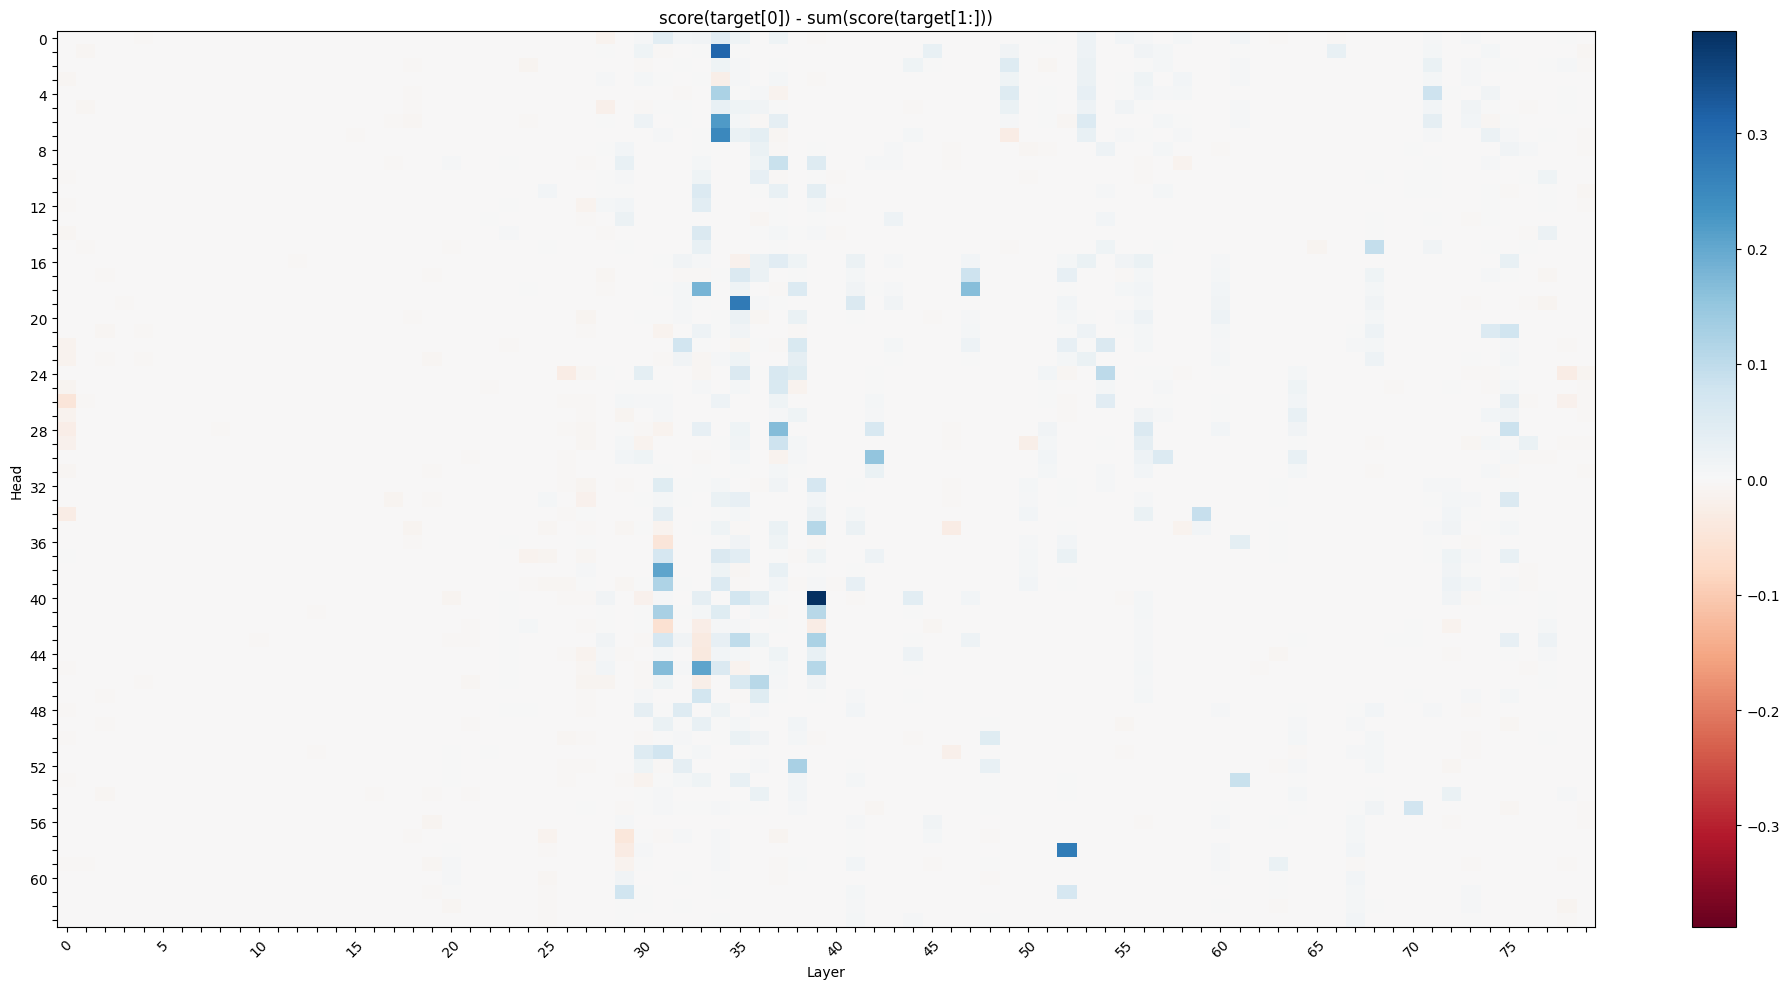

Layer 39, Head 40: 0.3883
Layer 34, Head 1: 0.3070
Layer 35, Head 19: 0.2739
Layer 52, Head 58: 0.2704
Layer 34, Head 7: 0.2498
Layer 34, Head 6: 0.2211
Layer 31, Head 38: 0.2063
Layer 33, Head 45: 0.2047
Layer 33, Head 18: 0.1804
Layer 37, Head 28: 0.1681
Layer 31, Head 45: 0.1679
Layer 47, Head 18: 0.1666
Layer 42, Head 30: 0.1544
Layer 31, Head 41: 0.1272
Layer 38, Head 52: 0.1245


In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 10))
scale = torch.max(torch.abs(resolution_scores))
plt.imshow(
    resolution_scores.cpu().numpy(),
    cmap="RdBu",
    aspect="auto",
    vmin=-scale,
    vmax=scale,
)
plt.colorbar()
# plt.title(f"score(target) - max(score(distractors)) | {token_idx.upper()} tokens of options")
plt.title("score(target[0]) - sum(score(target[1:]))")
plt.xlabel("Layer")
plt.ylabel("Head")

def get_ticks(ticks, skip=5):
    ret = []
    for i in ticks:
        if i % skip == 0:
            ret.append(str(i))
        else:
            ret.append("")
    return ret

plt.xticks(
    ticks=range(n_layer),
    labels=get_ticks(range(n_layer)),
    rotation=45,
)
plt.yticks(
    ticks=range(n_head),
    labels=get_ticks(range(n_head), skip=4),
)

plt.tight_layout()
plt.show()


scores_per_head = []
for head_idx in range(n_head):
    for layer_idx in range(n_layer):
        scores_per_head.append(
            (head_idx, layer_idx, resolution_scores[head_idx, layer_idx].item())
        )

scores_per_head = sorted(scores_per_head, key=lambda x: x[2], reverse=True)
for head_idx, layer_idx, score in scores_per_head[:15]:
    print(f"Layer {layer_idx}, Head {head_idx}: {score:.4f}")

In [ ]:
HEADS = [(layer_idx, head_idx) for head_idx, layer_idx, score in scores_per_head[:70]]
print(HEADS)

[(39, 40), (34, 1), (35, 19), (52, 58), (34, 7), (34, 6), (31, 38), (33, 45), (33, 18), (37, 28), (31, 45), (47, 18), (42, 30), (31, 41), (38, 52), (39, 43), (34, 4), (31, 39), (39, 35), (39, 45), (36, 46), (39, 41), (54, 24), (35, 43), (68, 15), (59, 34), (61, 53), (37, 9), (75, 28), (37, 29), (71, 4), (47, 17), (75, 21), (29, 61), (32, 22), (31, 51), (70, 55), (33, 47), (35, 40), (39, 32), (31, 37), (31, 43), (52, 61), (42, 28), (37, 24), (37, 25), (38, 22), (35, 46), (35, 24), (41, 19), (75, 33), (34, 45), (33, 14), (34, 37), (54, 22), (35, 17), (56, 28), (53, 6), (33, 11), (57, 30), (38, 18), (34, 39), (74, 21), (49, 4), (49, 2), (39, 9), (32, 48), (30, 51), (36, 47), (31, 32)]


#### Based on Patching Score

In [ ]:
from scripts.patching_within_task import SelectionQprojPatchResult
from tqdm.auto import tqdm


q_proj_root = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/q_states_patching",
    mt.name.split("/")[-1],
)

#############################################
# LIMIT = 10
LIMIT = None
n_layer = mt.n_layer
n_head = mt.config.num_attention_heads
categories = [
    "profession",
    "nationality",
    "objects",
]
#############################################

q_proj_results = {cat: [] for cat in categories}

for category in categories:
    print(f"category: {category}")
    q_proj_path = os.path.join(q_proj_root, category)
    files = sorted(os.listdir(q_proj_path))
    LIMIT = LIMIT or len(files)
    q_proj_results[category] = []
    for file in tqdm(files[:LIMIT]):
        if not file.endswith(".json"):
            continue

        file_path = os.path.join(q_proj_path, file)
        q_proj_results[category].append(SelectionQprojPatchResult.load_from_json(file_path))
        # if len(q_proj_results) % 10 == 0:
        #     print(f"Loaded {len(q_proj_results)}/{LIMIT} files")



category: profession


  0%|          | 0/150 [00:00<?, ?it/s]

category: nationality


  0%|          | 0/150 [00:00<?, ?it/s]

category: objects


  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
combine_all_results = []
for category in categories:
    combine_all_results.extend(q_proj_results[category])

results_copy = copy.deepcopy(q_proj_results)
results_copy["all"] = combine_all_results

Exception ignored in: <function tqdm.__del__ at 0x7f5c2f47e160>
Traceback (most recent call last):
  File "/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/tqdm/std.py", line 1147, in __del__
    def __del__(self):

KeyboardInterrupt: 


In [ ]:
len(results_copy["profession"])

150

2025-08-10 11:57:02 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f13dce7e9d0>


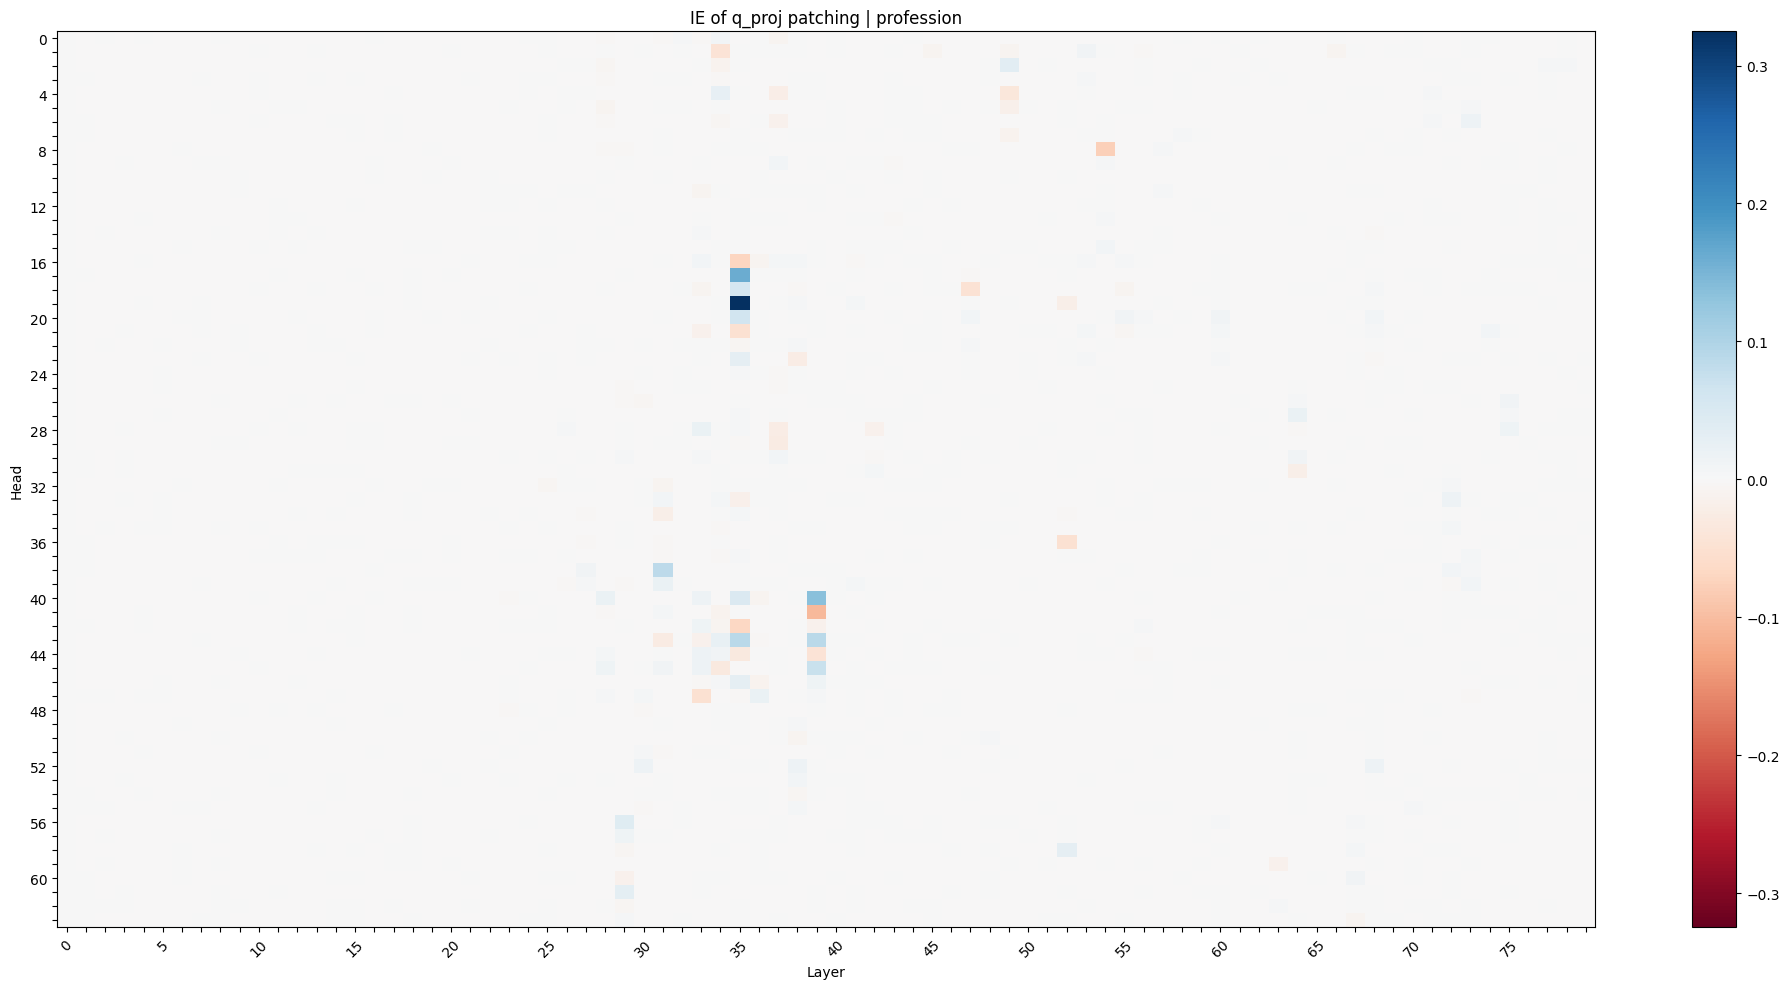

Layer 35, Head 19: 0.3248
Layer 35, Head 17: 0.1599
Layer 39, Head 40: 0.1348
Layer 39, Head 43: 0.0881
Layer 35, Head 43: 0.0880
Layer 31, Head 38: 0.0852
Layer 39, Head 45: 0.0720
Layer 35, Head 20: 0.0617
Layer 35, Head 18: 0.0551
Layer 35, Head 40: 0.0461
Layer 29, Head 56: 0.0398
Layer 49, Head 2: 0.0334
Layer 29, Head 61: 0.0324
Layer 52, Head 58: 0.0303
Layer 35, Head 23: 0.0298
2025-08-10 11:57:05 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f13ddcd8250>


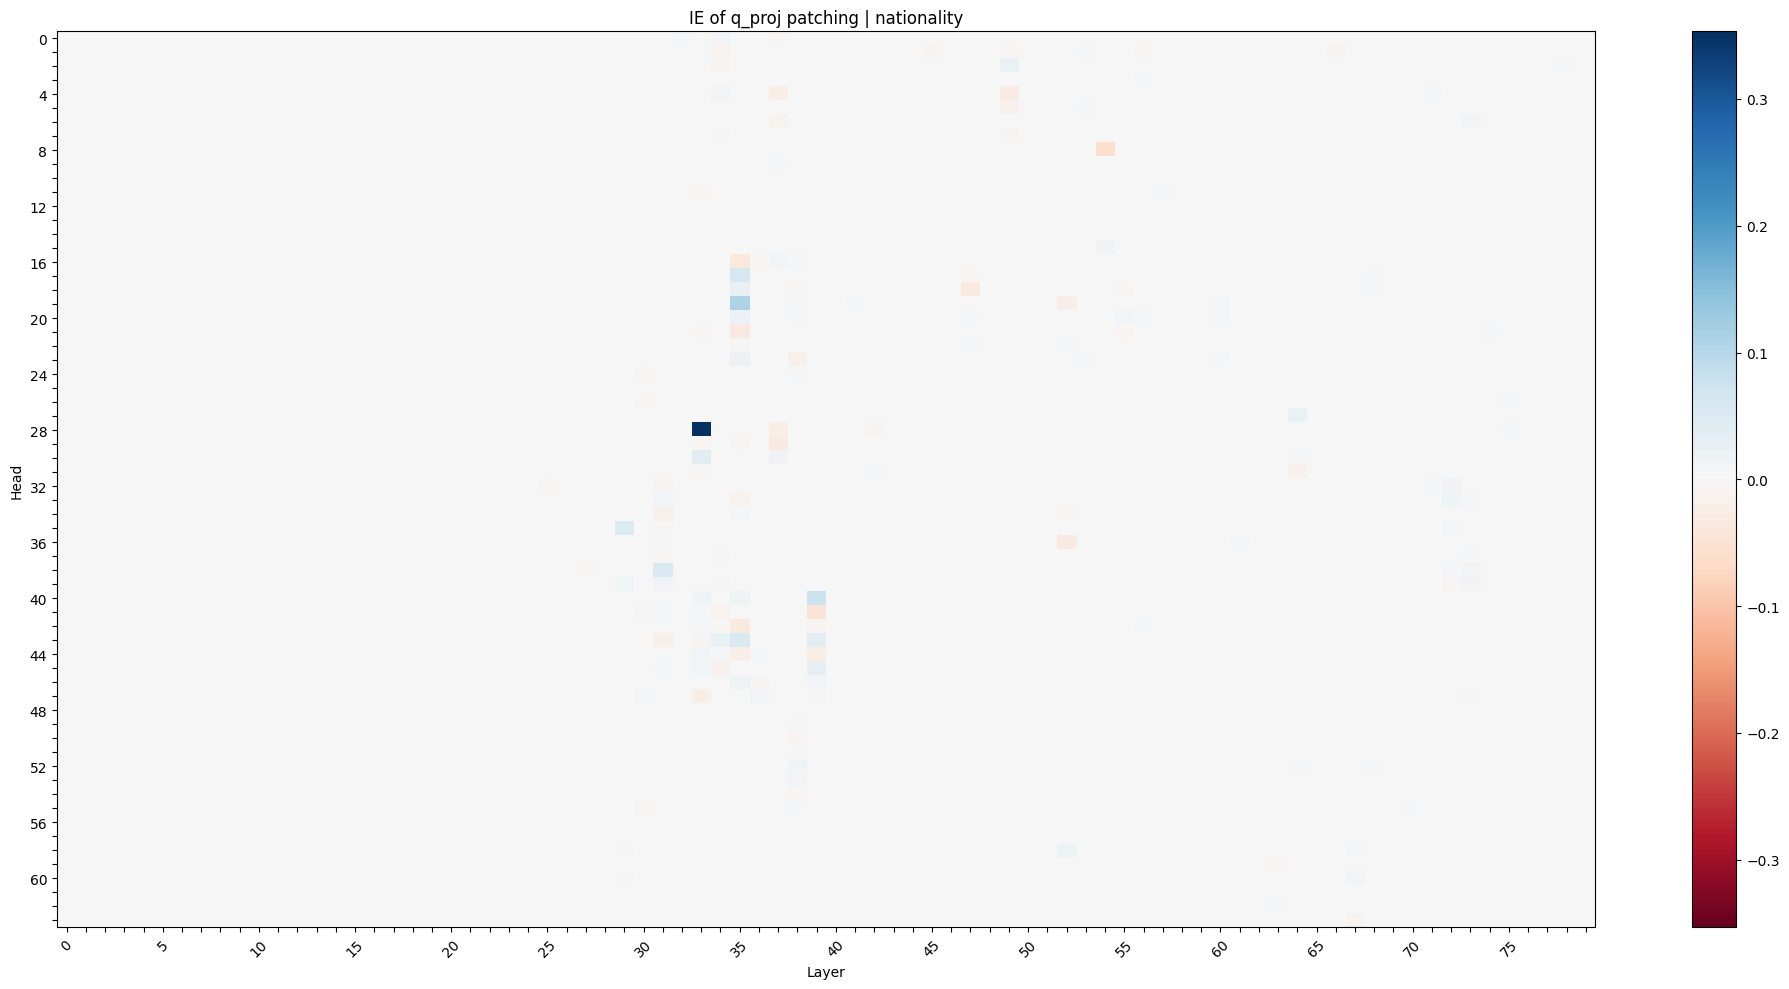

Layer 33, Head 28: 0.3533
Layer 35, Head 19: 0.1081
Layer 39, Head 40: 0.0748
Layer 35, Head 17: 0.0591
Layer 31, Head 38: 0.0549
Layer 35, Head 43: 0.0528
Layer 29, Head 35: 0.0495
Layer 39, Head 43: 0.0403
Layer 33, Head 30: 0.0362
Layer 39, Head 45: 0.0306
Layer 35, Head 18: 0.0274
Layer 34, Head 43: 0.0253
Layer 49, Head 2: 0.0233
Layer 64, Head 27: 0.0224
Layer 35, Head 20: 0.0211
2025-08-10 11:57:07 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f13decfb750>


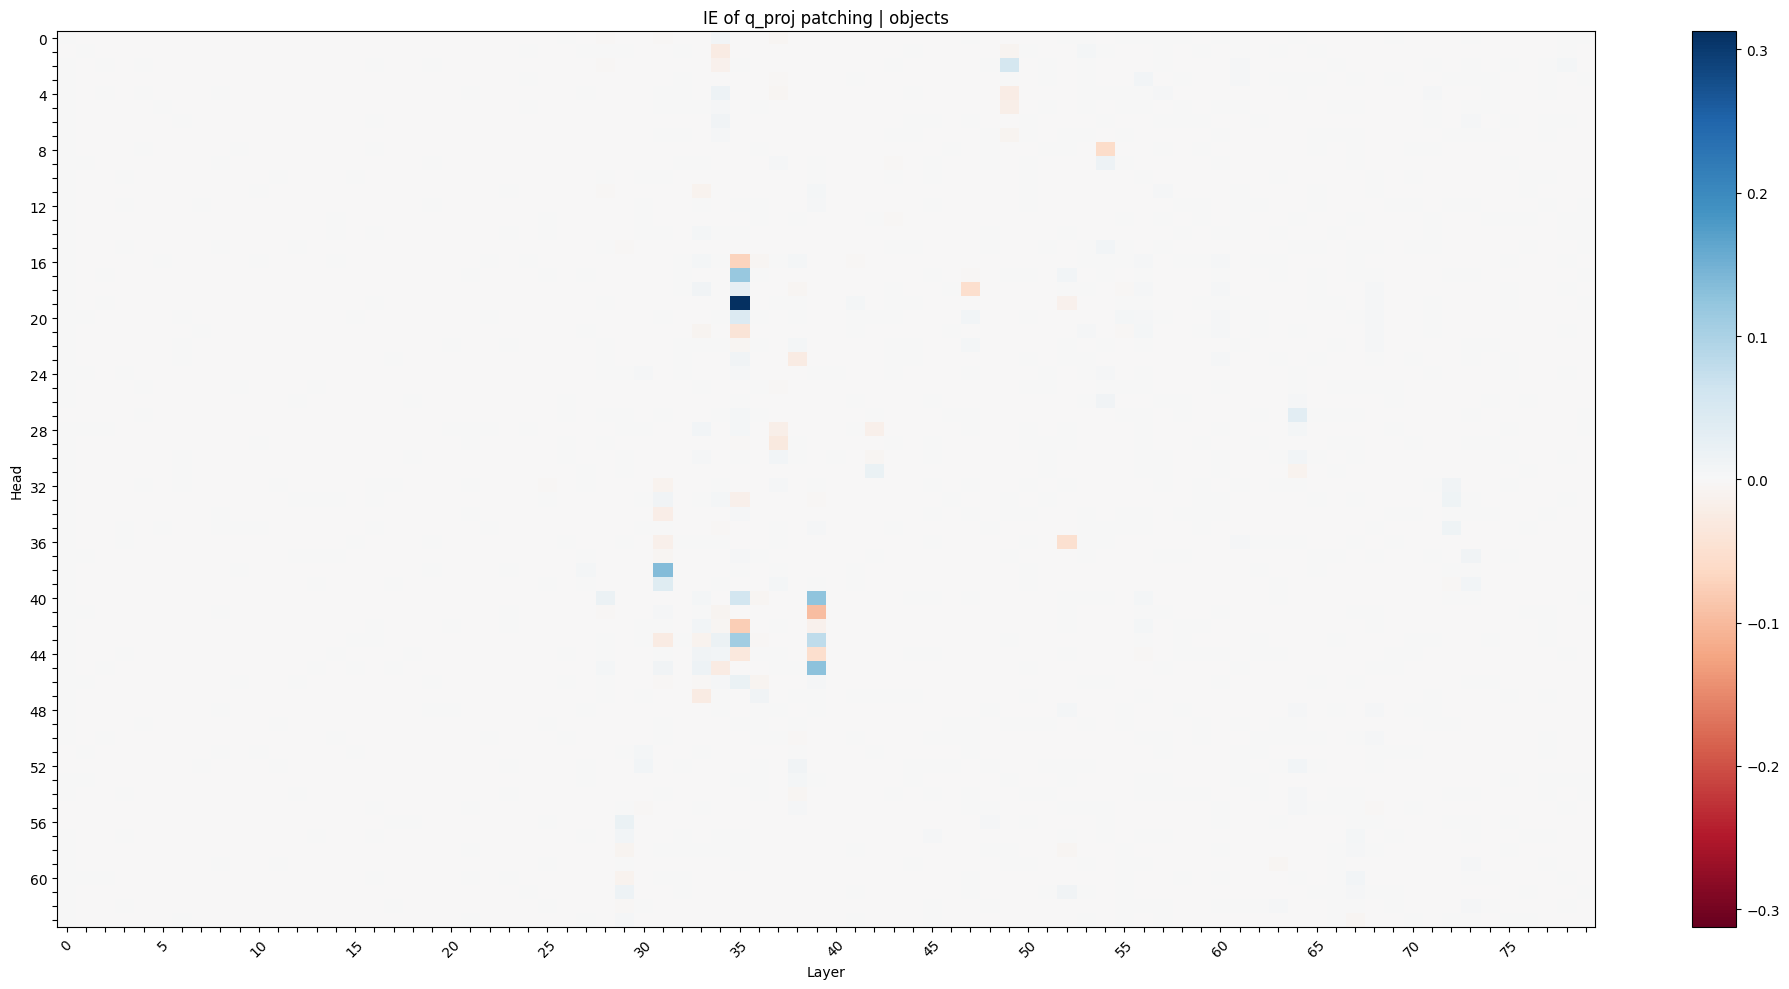

Layer 35, Head 19: 0.3127
Layer 31, Head 38: 0.1344
Layer 39, Head 45: 0.1280
Layer 39, Head 40: 0.1267
Layer 35, Head 17: 0.1187
Layer 35, Head 43: 0.1093
Layer 39, Head 43: 0.0782
Layer 35, Head 40: 0.0585
Layer 49, Head 2: 0.0557
Layer 35, Head 20: 0.0431
Layer 31, Head 39: 0.0375
Layer 64, Head 27: 0.0333
Layer 35, Head 18: 0.0262
Layer 29, Head 56: 0.0206
Layer 42, Head 31: 0.0205
2025-08-10 11:57:13 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f13e03b8290>


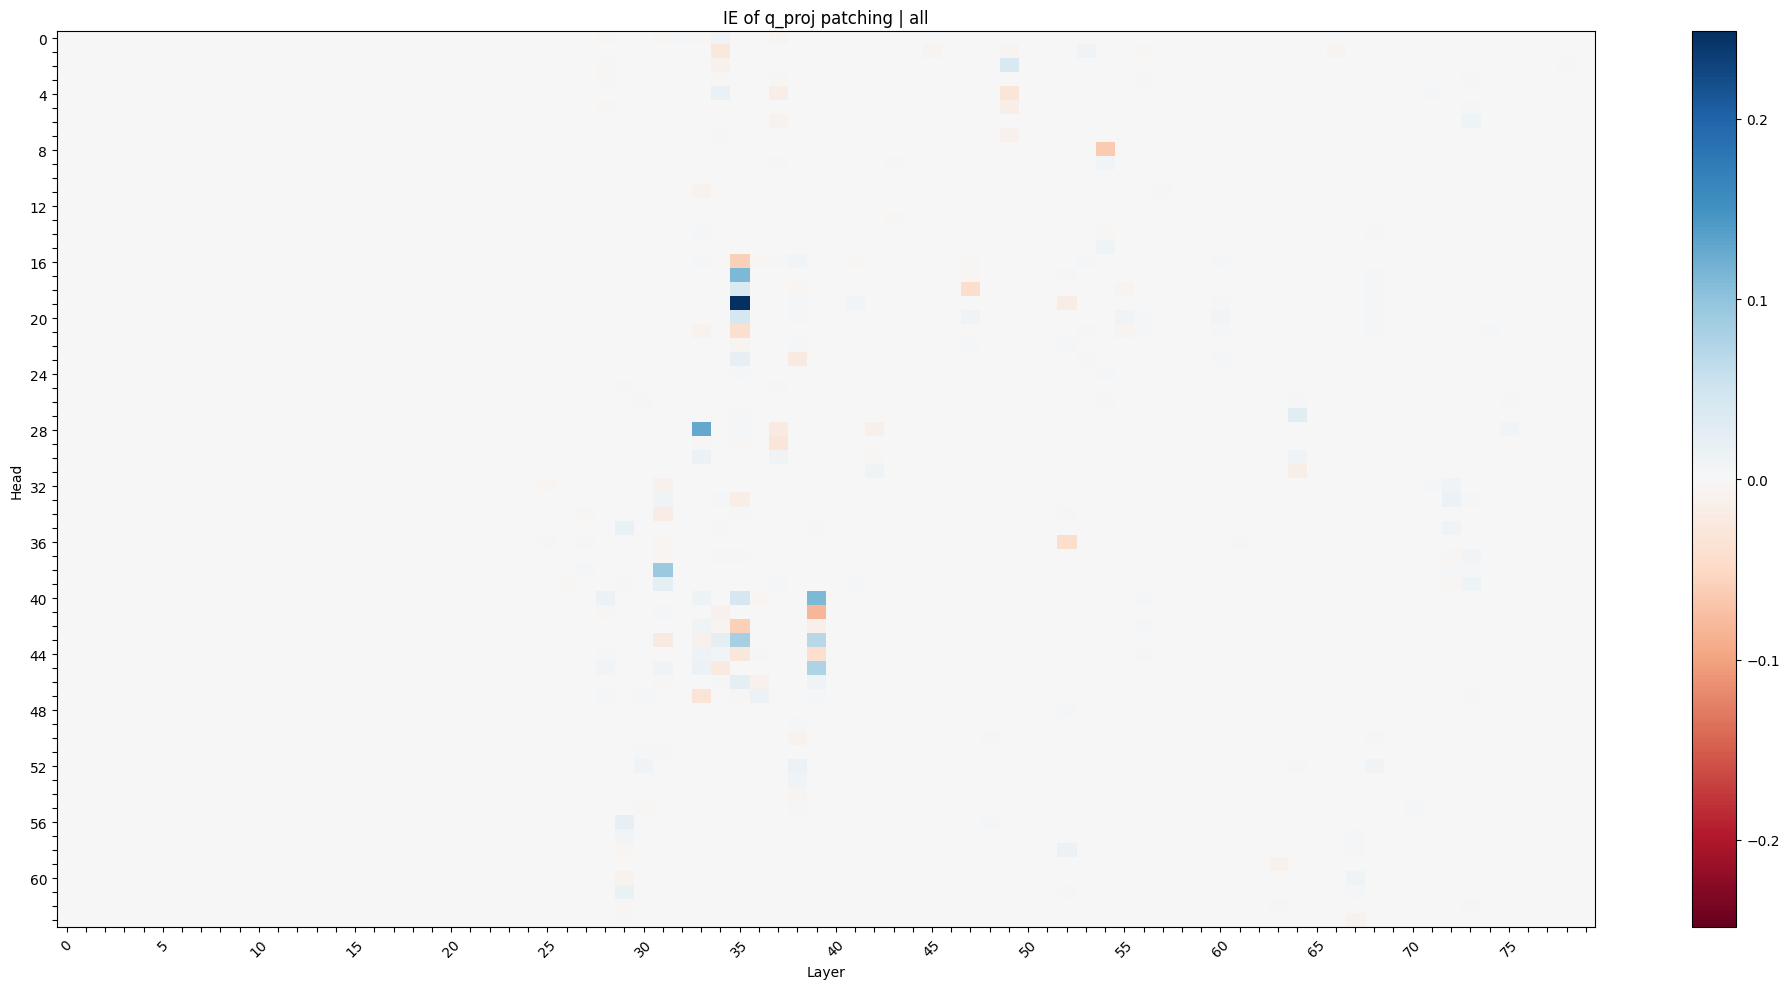

Layer 35, Head 19: 0.2485
Layer 33, Head 28: 0.1277
Layer 35, Head 17: 0.1126
Layer 39, Head 40: 0.1121
Layer 31, Head 38: 0.0915
Layer 35, Head 43: 0.0834
Layer 39, Head 45: 0.0769
Layer 39, Head 43: 0.0689
Layer 35, Head 20: 0.0420
Layer 35, Head 40: 0.0412
Layer 49, Head 2: 0.0375
Layer 35, Head 18: 0.0362
Layer 64, Head 27: 0.0256
Layer 31, Head 39: 0.0239
Layer 35, Head 46: 0.0223


In [ ]:
from matplotlib import pyplot as plt

category_wise_heads = {}
for category, categorywise_result in results_copy.items():
    indirect_effects = torch.zeros((n_layer, n_heads), dtype=torch.float32)
    for layer_idx in range(mt.n_layer):
        for head_idx in range(mt.config.num_attention_heads):
            indirect_effects[layer_idx, head_idx] = torch.mean(
                torch.tensor(
                    [
                        sample_result.head_effect(layer_idx, head_idx)
                        for sample_result in categorywise_result
                    ]
                )
            )

    plt.figure(figsize=(20, 10))
    scale = torch.max(torch.abs(indirect_effects))
    plt.imshow(
        indirect_effects.T.cpu().numpy(),
        cmap="RdBu",
        aspect="auto",
        vmin=-scale,
        vmax=scale,
    )
    plt.colorbar()
    # plt.title(f"score(target) - max(score(distractors)) | {token_idx.upper()} tokens of options")
    plt.title("IE of q_proj patching | " + category)
    plt.xlabel("Layer")
    plt.ylabel("Head")

    def get_ticks(ticks, skip=5):
        ret = []
        for i in ticks:
            if i % skip == 0:
                ret.append(str(i))
            else:
                ret.append("")
        return ret

    plt.xticks(
        ticks=range(n_layer),
        labels=get_ticks(range(n_layer)),
        rotation=45,
    )
    plt.yticks(
        ticks=range(n_head),
        labels=get_ticks(range(n_head), skip=4),
    )

    plt.tight_layout()
    plt.show()


    scores_per_head = []
    for layer_idx in range(n_layer):
        for head_idx in range(n_head):
            scores_per_head.append(
                (layer_idx, head_idx, indirect_effects[layer_idx, head_idx].item())
            )

    scores_per_head = sorted(scores_per_head, key=lambda x: x[2], reverse=True)
    category_wise_heads[category] = scores_per_head
    for layer_idx, head_idx, score in scores_per_head[:15]:
        print(f"Layer {layer_idx}, Head {head_idx}: {score:.4f}")

#### Performing the Patch

In [36]:
from src.tokens import prepare_input
from src.functional import get_module_nnsight

HEADS = [
    (33, 45),
    (33, 18),
    (34, 1),
    (34, 6),
    (34, 7),
    (35, 19),
    (39, 40),
    (42, 30),
    (47, 18),
    (52, 58),
]

# HEADS = [
#     (layer_idx, head_idx)
#     for layer_idx, head_idx, score in category_wise_heads["all"][:50]
# ]

# HEADS = heads_selected

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)
patch_tokenized = prepare_input(prompts=patch_sample.prompt(), tokenizer=mt)

# category_wise_heads["all"][len(HEADS) - 1]

In [41]:
from src.utils.typing import TokenizerOutput
@torch.inference_mode()
def cache_q_projections(
    mt: ModelandTokenizer,
    input: TokenizerOutput,
    heads: list[tuple[int, int]],
    query_idx: int = -1,
    return_output: bool = False,
):
    layer_to_heads = {}
    for layer_idx, head_idx in heads:
        if layer_idx not in layer_to_heads:
            layer_to_heads[layer_idx] = []
        layer_to_heads[layer_idx].append(head_idx)

    q_projections = {}
    batch_size = input.input_ids.shape[0]
    seq_len = input.input_ids.shape[1]
    n_heads = mt.config.num_attention_heads
    head_dim = mt.n_embd // n_heads
    with mt.trace(input) as tracer:
        for layer_idx, head_indices in layer_to_heads.items():
            q_proj_name = mt.attn_module_name_format.format(layer_idx) + ".q_proj"
            q_proj_module = get_module_nnsight(mt, q_proj_name)
            q_proj_out = q_proj_module.output.view(batch_size, seq_len, n_heads, head_dim).transpose(1, 2)
            for head_idx in head_indices:
                q_projections[(layer_idx, head_idx)] = q_proj_out[:, head_idx, query_idx, :].squeeze().save()

        if return_output:
            output = mt.output.save()
    
    if return_output:
        return q_projections, output
    return q_projections

In [38]:
cached_q_states = cache_q_projections(
    mt=mt,
    input=patch_tokenized,
    heads=HEADS,
    # heads=[(35, 19)],
    # heads=patching_heads,
    query_idx=-1
)

# cached_q_states[(HEADS[0])].shape

In [39]:
from src.attention import get_attention_matrices, visualize_attn_matrix
from src.functional import interpret_logits

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)

# attn_info = get_attention_matrices(
#     input=clean_tokenized,
#     mt=mt,
# )

# layer_idx, head_idx = 35, 19
# attn_matrix = attn_info.attention_matrices[layer_idx, head_idx].squeeze()
# visualize_attn_matrix(
#     attn_matrix=attn_matrix,
#     tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
#     q_index=-1,
# )

# interpret_logits(
#     tokenizer=mt,
#     logits=attn_info.logits,
#     interested_tokens=[clean_sample.obj_token_id, clean_sample.metadata["track_type_obj_token_id"]]
# )

attn_pattern = verify_head_patterns(
    prompt = clean_tokenized,
    options = clean_sample.options,
    pivot = clean_sample.subj,
    mt = mt,
    heads = HEADS,
    # heads = patching_heads,
    generate_full_answer=True,
)

attn_pattern["predictions"]

0 patches to ablate possible answer information from options
2025-08-10 20:16:55 src.experiments.utils DEBUG    Generated full answer: " Bed.
Explanation: A bed is a piece of furniture that is designed for sleeping or resting. It is typically found in a bedroom and is a common"
2025-08-10 20:16:55 src.experiments.utils DEBUG    Predictions: ['" Bed"[13394] (p=0.914, logit=22.125)', '" The"[578] (p=0.021, logit=18.375)', '" Among"[22395] (p=0.015, logit=18.000)', '" A"[362] (p=0.009, logit=17.500)', '" Sink"[57551] (p=0.005, logit=16.875)']
2025-08-10 20:16:55 src.experiments.utils INFO     Combined attention matrix for all heads


[PredictedToken(token=' Bed', prob=0.9140625, logit=22.125, token_id=13394, metadata=None),
 PredictedToken(token=' The', prob=0.021484375, logit=18.375, token_id=578, metadata=None),
 PredictedToken(token=' Among', prob=0.0147705078125, logit=18.0, token_id=22395, metadata=None),
 PredictedToken(token=' A', prob=0.00897216796875, logit=17.5, token_id=362, metadata=None),
 PredictedToken(token=' Sink', prob=0.004791259765625, logit=16.875, token_id=57551, metadata=None)]

In [40]:
from src.attention import get_attention_matrices, visualize_attn_matrix
from src.functional import patch_with_nnsight, patch_with_baukit, PatchSpec

q_proj_patches = []
for (layer_idx, head_idx), q_proj in cached_q_states.items():
    q_proj_patches.append(
        PatchSpec(
            location=(mt.attn_module_name_format.format(layer_idx) + ".q_proj", head_idx, -1),
            patch=q_proj
        )
    )

# patched_attn_info = get_attention_matrices(
#     input=clean_tokenized,
#     mt=mt,
#     patches=q_proj_patches,
#     patch_interface=patch_with_baukit
# )

# layer_idx, head_idx = 35, 19
# patched_attn_matrix = patched_attn_info.attention_matrices[layer_idx, head_idx].squeeze()
# visualize_attn_matrix(
#     attn_matrix=patched_attn_matrix,
#     tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
#     q_index=-1,
# )

# interpret_logits(
#     tokenizer=mt,
#     logits=patched_attn_info.logits,
#     interested_tokens=[clean_sample.obj_token_id, clean_sample.metadata["track_type_obj_token_id"]]
# )

patched_attn_pattern = verify_head_patterns(
    prompt = clean_tokenized,
    options = clean_sample.options,
    pivot = clean_sample.subj,
    mt = mt,
    heads = HEADS,
    # heads = patching_heads,
    query_patches=q_proj_patches,
    # generate_full_answer=True,
)

patched_attn_pattern["predictions"]

10 patches to ablate possible answer information from options
2025-08-10 20:16:56 src.experiments.utils DEBUG    Predictions: ['" Bed"[13394] (p=0.844, logit=21.375)', '" The"[578] (p=0.033, logit=18.125)', '" Among"[22395] (p=0.022, logit=17.750)', '" Pants"[67553] (p=0.020, logit=17.625)', '" A"[362] (p=0.014, logit=17.250)']
2025-08-10 20:16:56 src.experiments.utils INFO     Combined attention matrix for all heads


[PredictedToken(token=' Bed', prob=0.84375, logit=21.375, token_id=13394, metadata=None),
 PredictedToken(token=' The', prob=0.03271484375, logit=18.125, token_id=578, metadata=None),
 PredictedToken(token=' Among', prob=0.0224609375, logit=17.75, token_id=22395, metadata=None),
 PredictedToken(token=' Pants', prob=0.019775390625, logit=17.625, token_id=67553, metadata=None),
 PredictedToken(token=' A', prob=0.01361083984375, logit=17.25, token_id=362, metadata=None)]

### Search over layers and heads

In [ ]:
clean_sample.metadata

{'track_category': 'furniture',
 'track_type_obj': 'Recliner',
 'track_type_obj_idx': 0,
 'track_type_obj_token_id': 1050}

In [ ]:
from scripts.patching_within_task import SelectionQprojPatchResult

In [ ]:
from itertools import product
from src.functional import patch_with_baukit, interpret_logits

interested_tokens = [
    patch_sample.obj_token_id,
    clean_sample.obj_token_id,
    clean_sample.metadata["track_type_obj_token_id"]
]
all_heads = list(product(range(20, 60), range(mt.config.num_attention_heads)))
all_q_projections, patch_out = cache_q_projections(
    mt=mt,
    input=patch_tokenized,
    heads=all_heads,
    query_idx=-1,
    return_output=True
)
logger.debug(len(all_q_projections))

patch_logits = patch_out.logits[:, -1, :].squeeze()
patch_precitions, patch_track = interpret_logits(
    tokenizer=mt,
    logits=patch_logits,
    interested_tokens=interested_tokens,
)

patch_precitions, patch_track

2025-08-10 19:53:13 __main__ DEBUG    2560


([PredictedToken(token=' Bed', prob=0.8515625, logit=22.125, token_id=13394, metadata=None),
  PredictedToken(token=' The', prob=0.048095703125, logit=19.25, token_id=578, metadata=None),
  PredictedToken(token=' Among', prob=0.037353515625, logit=19.0, token_id=22395, metadata=None),
  PredictedToken(token=' A', prob=0.02001953125, logit=18.375, token_id=362, metadata=None),
  PredictedToken(token=' BED', prob=0.00506591796875, logit=17.0, token_id=83364, metadata=None)],
 {13394: (1,
   PredictedToken(token=' Bed', prob=0.8515625, logit=22.125, token_id=13394, metadata=None)),
  1050: (252,
   PredictedToken(token=' Re', prob=3.382563591003418e-06, logit=9.6875, token_id=1050, metadata=None)),
  3341: (459,
   PredictedToken(token=' Car', prob=1.0952353477478027e-06, logit=8.5625, token_id=3341, metadata=None))})

In [ ]:
clean_out = patch_with_baukit(
    mt=mt,
    inputs=clean_tokenized,
    patches=[],
)

base_logits = clean_out.logits[:, -1, :].squeeze()
base_predictions, base_track = interpret_logits(
    tokenizer=mt,
    logits=base_logits,
    interested_tokens=interested_tokens,
)
base_predictions, base_track

([PredictedToken(token=' Printer', prob=0.87890625, logit=21.75, token_id=47033, metadata=None),
  PredictedToken(token=' The', prob=0.0301513671875, logit=18.375, token_id=578, metadata=None),
  PredictedToken(token=' Among', prob=0.020751953125, logit=18.0, token_id=22395, metadata=None),
  PredictedToken(token=' A', prob=0.020751953125, logit=18.0, token_id=362, metadata=None),
  PredictedToken(token=' None', prob=0.0067138671875, logit=16.875, token_id=2290, metadata=None)],
 {47033: (1,
   PredictedToken(token=' Printer', prob=0.87890625, logit=21.75, token_id=47033, metadata=None)),
  423: (42,
   PredictedToken(token=' D', prob=0.000148773193359375, logit=13.0625, token_id=423, metadata=None)),
  47589: (696,
   PredictedToken(token=' Basketball', prob=9.387731552124023e-07, logit=8.0, token_id=47589, metadata=None))})

In [ ]:
int_out = patch_with_baukit(
    mt = mt,
    inputs = clean_tokenized,
    patches = q_proj_patches,
)

logits = int_out.logits[:, -1, :].squeeze()

interpret_logits(
    tokenizer=mt,
    logits=logits,
    interested_tokens=interested_tokens
)

([PredictedToken(token=' Basketball', prob=0.462890625, logit=20.375, token_id=47589, metadata=None),
  PredictedToken(token=' Printer', prob=0.359375, logit=20.125, token_id=47033, metadata=None),
  PredictedToken(token=' None', prob=0.0380859375, logit=17.875, token_id=2290, metadata=None),
  PredictedToken(token=' Among', prob=0.029541015625, logit=17.625, token_id=22395, metadata=None),
  PredictedToken(token=' The', prob=0.029541015625, logit=17.625, token_id=578, metadata=None)],
 {47589: (1,
   PredictedToken(token=' Basketball', prob=0.462890625, logit=20.375, token_id=47589, metadata=None)),
  47033: (2,
   PredictedToken(token=' Printer', prob=0.359375, logit=20.125, token_id=47033, metadata=None)),
  423: (85,
   PredictedToken(token=' D', prob=7.343292236328125e-05, logit=11.625, token_id=423, metadata=None))})

In [ ]:
head_wise_patching_effects = {}

for (layer_idx, head_idx), q_proj in tqdm(all_q_projections.items()):
    q_proj_patch = PatchSpec(
        location=(mt.attn_module_name_format.format(layer_idx) + ".q_proj", head_idx, -1),
        patch=q_proj
    )
    out = patch_with_baukit(
        mt = mt,
        inputs = clean_tokenized,
        patches = [q_proj_patch],
    )
    logits = out.logits[:, -1, :].squeeze()
    predictions, track = interpret_logits(
        tokenizer=mt,
        logits=logits,
        interested_tokens=interested_tokens
    )
    head_wise_patching_effects[(layer_idx, head_idx)] = track

  0%|          | 0/2560 [00:00<?, ?it/s]

Patched Layer 21, Head 35: [PredictedToken(token=' Will', prob=0.5625, logit=20.25, token_id=4946, metadata=None), PredictedToken(token=' (', prob=0.09765625, logit=18.5, token_id=320, metadata=None), PredictedToken(token=' Option', prob=0.076171875, logit=18.25, token_id=7104, metadata=None), PredictedToken(token=' ', prob=0.076171875, logit=18.25, token_id=220, metadata=None), PredictedToken(token=' The', prob=0.046142578125, logit=17.75, token_id=578, metadata=None)] | {4946: (1, PredictedToken(token=' Will', prob=0.5625, logit=20.25, token_id=4946, metadata=None)), 35336: (33, PredictedToken(token=' Nancy', prob=0.000659942626953125, logit=13.5, token_id=35336, metadata=None)), 11519: (639, PredictedToken(token=' Mike', prob=2.5331974029541016e-06, logit=7.9375, token_id=11519, metadata=None))}
Patched Layer 23, Head 7: [PredictedToken(token=' Will', prob=0.55859375, logit=20.25, token_id=4946, metadata=None), PredictedToken(token=' (', prob=0.09716796875, logit=18.5, token_id=320,

In [ ]:
patching_results = SelectionQprojPatchResult(
    patch_sample=patch_sample,
    clean_sample=clean_sample,
    interested_tokens=interested_tokens,
    base_results=base_track,
    gold_results=patch_track,
    headwise_patching_effects=head_wise_patching_effects
)

NameError: name 'head_wise_patching_effects' is not defined

In [ ]:
patching_results.head_effect(layer_idx=35, head_idx=19)

0.4214876033057851

In [ ]:
headwise_scores = [
    (
        layer_idx,
        head_idx,
        patching_results.head_effect(layer_idx, head_idx)
    )
    for layer_idx, head_idx in head_wise_patching_effects.keys()
]

headwise_scores = sorted(headwise_scores, key=lambda x: x[2], reverse=True)
patching_heads = []
for layer_idx, head_idx, score in headwise_scores[:15]:
    print(f"Layer {layer_idx}, Head {head_idx}: {score:.4f}")
    patching_heads.append((layer_idx, head_idx))

Layer 35, Head 19: 0.4215
Layer 39, Head 45: 0.2645
Layer 39, Head 43: 0.2397
Layer 31, Head 38: 0.1983
Layer 35, Head 20: 0.1818
Layer 35, Head 23: 0.0992
Layer 35, Head 43: 0.0992
Layer 35, Head 17: 0.0826
Layer 49, Head 2: 0.0744
Layer 31, Head 33: 0.0661
Layer 37, Head 30: 0.0661
Layer 35, Head 18: 0.0579
Layer 30, Head 52: 0.0496
Layer 31, Head 39: 0.0496
Layer 33, Head 47: 0.0496


In [ ]:
patching_results.delist_patching_effects()
with open("patching_results.json", "w") as f:
    json.dump(patching_results.to_dict(), f, indent=4)

In [ ]:
with open("patching_results.json", "r") as f:
    loaded_results = json.load(f)

loaded_results["headwise_patching_effects"] = {
    (int(layer_idx.split("_<>_")[0]), int(layer_idx.split("_<>_")[1])): effect
    for layer_idx, effect in loaded_results["headwise_patching_effects"].items()
}

In [ ]:
loaded_results["headwise_patching_effects"].keys()

In [ ]:
patching_results_loaded = SelectionQprojPatchResult.from_dict(loaded_results)
patching_results_loaded.head_effect(layer_idx=35, head_idx=19)

0.4214876033057851

In [ ]:
mt.config.num_attention_heads

64

## Optimization to select heads to patch

In [42]:
from torch.optim import AdamW
from torch.utils.data import DataLoader
from src.utils.typing import TokenizerOutput
from src.functional import free_gpu_cache
import baukit

def get_optimal_head_mask(
    mt: ModelandTokenizer,
    train_set: list[tuple[SelectionSample, SelectionSample]],
    learning_rate: float = 1e-3,
    n_epochs: int = 5,
    lamb: float = 1e-3,
    batch_size: int = 4,
    query_idx: int = -1,
): 
    n_layer = mt.n_layer
    n_heads = mt.config.num_attention_heads

    mask = torch.ones((n_layer, n_heads), dtype=mt.dtype, requires_grad=True, device=mt.device)

    # prompts = []
    # prompts.extend([sample.prompt() for sample in clean_samples])
    # prompts.extend([sample.prompt() for sample in patch_samples])
    # tokenized = prepare_input(prompts=prompts, tokenizer=mt)

    # clean_tokenized = TokenizerOutput(data = {k: v[:len(clean_samples), :] for k, v in tokenized.items()})
    # patch_tokenized = TokenizerOutput(data = {k: v[len(clean_samples):, :] for k, v in tokenized.items()})

    optimizer = AdamW([mask], lr=learning_rate)
    losses = []

    all_heads = [(layer_idx, head_idx) for layer_idx in range(n_layer) for head_idx in range(n_heads)]
    all_q_proj_modules = [
        mt.attn_module_name_format.format(layer_idx) + ".q_proj"
        for layer_idx in range(n_layer)
    ]
    batches = []
    for batch_start in range(0, len(train_set), batch_size):
        batches.append(train_set[batch_start:batch_start + batch_size])
    
    logger.info("Caching q projections from patch samples...")
    q_projections_from_patch_samples = {}
    for batch_idx, batch in enumerate(batches):
        clean_samples, patch_samples = zip(*batch)
        prompts = []
        prompts.extend([sample.prompt() for sample in clean_samples])
        prompts.extend([sample.prompt() for sample in patch_samples])
        tokenized = prepare_input(prompts=prompts, tokenizer=mt)
        # clean_tokenized = TokenizerOutput(data = {k: v[:len(clean_samples), :] for k, v in tokenized.items()})
        patch_tokenized = TokenizerOutput(data = {k: v[len(clean_samples):, :] for k, v in tokenized.items()})

        q_projections = cache_q_projections(
            mt=mt,
            input=patch_tokenized,
            heads=all_heads,
            query_idx=query_idx
        )

        patches = {}
        for (layer_idx, head_idx), q_proj in q_projections.items():
            module_name = mt.attn_module_name_format.format(layer_idx) + ".q_proj"
            patches[(module_name, head_idx)] = (layer_idx, q_proj)
        q_projections_from_patch_samples[batch_idx] = patches
        logger.info(f"Caching completed > {batch_idx+1}/{len(batches)} batches.")
        free_gpu_cache()

    logger.info("Starting training...")

    for epoch in range(n_epochs):
        epoch_loss = 0
        for batch_idx, batch in enumerate(batches):
            optimizer.zero_grad()

            batch_size_actual = len(batch)

            clean_samples, patch_samples = zip(*batch)
            prompts = []
            prompts.extend([sample.prompt() for sample in clean_samples])
            prompts.extend([sample.prompt() for sample in patch_samples])
            tokenized = prepare_input(prompts=prompts, tokenizer=mt)
            clean_tokenized = TokenizerOutput(data = {k: v[:len(clean_samples), :] for k, v in tokenized.items()})
            patch_tokenized = TokenizerOutput(data = {k: v[len(clean_samples):, :] for k, v in tokenized.items()})
            batch_target_tokens = [
                clean_sample.metadata["track_type_obj_token_id"]
                for clean_sample in clean_samples
            ]

            patch_q_states = q_projections_from_patch_samples[batch_idx]

            batch_size = clean_tokenized.input_ids.shape[0]
            seq_len = clean_tokenized.input_ids.shape[1]
            head_dim = mt.n_embd // n_heads

            def perform_patch(
                repr, layer_name
            ):
                if layer_name not in all_q_proj_modules:
                    return repr

                repr = repr.view(
                    batch_size, seq_len, n_heads, head_dim
                ).transpose(1, 2)
                for head_idx in range(n_heads):
                    q_clean = repr[:, head_idx, query_idx, :]
                    layer_idx, q_patch = patch_q_states[(layer_name, head_idx)]
                    q_patch = q_patch.clone().to(q_clean.dtype).to(q_clean.device)
                    q_patch.requires_grad = True
                    coeff = mask[layer_idx, head_idx].to(q_clean.dtype).to(q_clean.device)
                    # head_patch = coeff * q_patch + (1 - coeff) * q_clean
                    repr[:, head_idx, query_idx, :] += coeff * (q_patch - q_clean)

                repr = repr.transpose(1, 2).view(batch_size, seq_len, n_heads * head_dim)
                return repr
            
            with baukit.TraceDict(
                module = mt._model,
                layers = all_q_proj_modules,
                edit_output=perform_patch
            ):
                output = mt._model(**clean_tokenized)
            
            logits = output.logits[:, -1, :]

            # calculate target loss
            target_logits = [logit[tok] for logit, tok in zip(logits, batch_target_tokens)]
            target_loss = -torch.stack(target_logits).mean()  # need this to go up

            # mask_loss
            mask_l1_loss = torch.abs(mask).sum() * lamb
            loss = target_loss + mask_l1_loss
            logger.debug(f"Epoch={epoch+1} | {batch_idx=} |>> {target_loss.item():.4f} + {mask_l1_loss.item():.4f} = {loss.item():.4f}")

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                mask.clamp_(1e-3, 1)
            
            epoch_loss += loss.item() * batch_size_actual
            losses.append(loss.item())


        epoch_loss /= len(train_set)
        logger.info(f"Epoch {epoch+1}/{n_epochs} completed. Avg Loss: {epoch_loss:.4f}")

    with torch.no_grad():
        mask.clamp_(0, 1)

    free_gpu_cache()
    return mask.detach().cpu(), losses

In [43]:
# print(clean_sample.prompt(), ">>", clean_sample.obj)
# print(patch_sample.prompt(), ">>", patch_sample.obj)

# train_set = [(clean_sample, patch_sample)]


In [44]:
free_gpu_cache()
train_set = []
train_limit = 150

while len(train_set) < train_limit:
    patch, clean = get_counterfactual_samples_on_pivot_entity(
        filter_by_lm_prediction=True,
        prompt_template_idx=3,
        option_style="single_line",
        distinct_options=True,
    )
    train_set.append((clean, patch))

2025-08-10 20:18:14 __main__ INFO     Patch category: vegetable, subject: Potato, object: Asparagus
2025-08-10 20:18:14 __main__ INFO     Clean category: kitchen appliance, subject: Rice cooker, object: Coffee maker
2025-08-10 20:18:14 __main__ INFO     patch_must_have_options=['Asparagus', 'Oven']
2025-08-10 20:18:14 __main__ INFO     clean_must_have_options=['Coffee maker', 'Potato']
2025-08-10 20:18:14 __main__ INFO     clean_type_obj='Oven'
2025-08-10 20:18:14 __main__ INFO     patch_type_obj='Potato'
2025-08-10 20:18:14 __main__ INFO     patch_obj_idx=1 | ['Shirt', 'Asparagus', 'Monkey', 'Bat', 'Oven', 'Van']
2025-08-10 20:18:14 __main__ INFO     clean_obj_idx=0 | ['Coffee maker', 'Clarinet', 'Earring', 'Potato', 'Jacket', 'Boxing gloves']
2025-08-10 20:18:14 __main__ INFO     Options: Shirt, Asparagus, Monkey, Bat, Oven, Van.
Which among these objects mentioned above is a vegetable?
Answer:
2025-08-10 20:18:14 __main__ INFO     Potato | vegetable -> Asparagus | pred=['" As"[1666]

In [46]:
len(train_set)

150

In [47]:
free_gpu_cache()

In [ ]:
free_gpu_cache()
optimal_mask, losses = get_optimal_head_mask(
    mt=mt,
    train_set=train_set,
    learning_rate=1e-3,
    n_epochs=10,
    lamb=3e-2,
    batch_size=4,
    query_idx=-1
)

2025-08-10 20:21:23 __main__ INFO     Caching q projections from patch samples...
2025-08-10 20:21:26 __main__ INFO     Caching completed > 1/38 batches.
2025-08-10 20:21:29 __main__ INFO     Caching completed > 2/38 batches.
2025-08-10 20:21:33 __main__ INFO     Caching completed > 3/38 batches.
2025-08-10 20:21:36 __main__ INFO     Caching completed > 4/38 batches.
2025-08-10 20:21:40 __main__ INFO     Caching completed > 5/38 batches.
2025-08-10 20:21:43 __main__ INFO     Caching completed > 6/38 batches.
2025-08-10 20:21:47 __main__ INFO     Caching completed > 7/38 batches.
2025-08-10 20:21:50 __main__ INFO     Caching completed > 8/38 batches.
2025-08-10 20:21:54 __main__ INFO     Caching completed > 9/38 batches.
2025-08-10 20:21:58 __main__ INFO     Caching completed > 10/38 batches.
2025-08-10 20:22:02 __main__ INFO     Caching completed > 11/38 batches.
2025-08-10 20:22:06 __main__ INFO     Caching completed > 12/38 batches.
2025-08-10 20:22:10 __main__ INFO     Caching compl

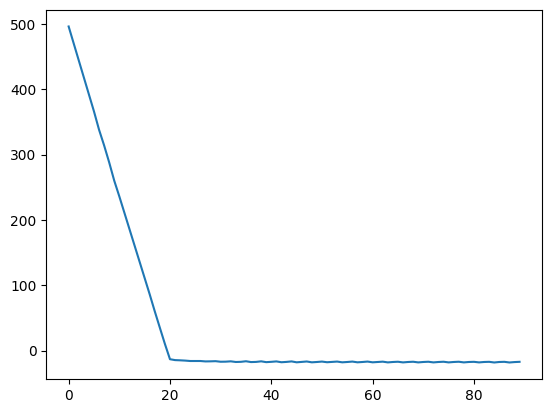

In [ ]:
from matplotlib import pyplot as plt
plt.plot(losses)

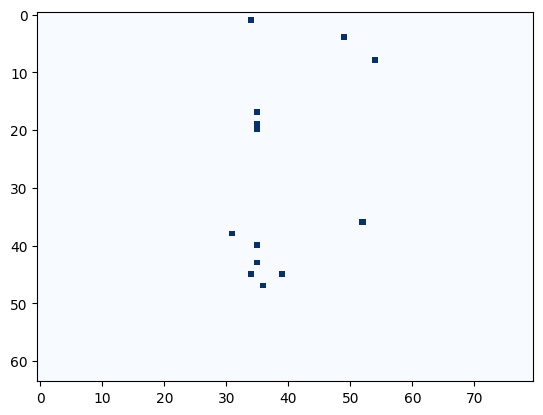

In [ ]:
plt.imshow(
    optimal_mask.round().T.to(torch.float32).numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

In [ ]:
heads_selected = torch.nonzero(optimal_mask > 0.5, as_tuple=False).tolist()

In [ ]:
heads_selected

[[31, 38],
 [34, 1],
 [34, 45],
 [35, 17],
 [35, 19],
 [35, 20],
 [35, 40],
 [35, 43],
 [36, 47],
 [39, 45],
 [49, 4],
 [52, 36],
 [54, 8]]

In [ ]:
len(heads_selected)

37

In [ ]:
optimal_mask.sum()

tensor(15.3750, dtype=torch.bfloat16)